In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
input_length = 168
output_length = 24

show_graph = True
result_save = True

In [3]:
# Group 2
# model_paths = ["Save_File/Grouped2_model_0602/A1.ckpt",
#                 "Save_File/Grouped2_model_0602/A2.ckpt",
#                 "Save_File/Grouped2_model_0602/A3.ckpt",
#                 "Save_File/Grouped2_model_0602/A4.ckpt",
#                 "Save_File/Grouped2_model_0602/A5.ckpt",
#                 "Save_File/Grouped2_model_0602/A6.ckpt",
#                 "Save_File/Grouped2_model_0602/A7.ckpt",
#                 "Save_File/Grouped2_model_0602/B1.ckpt",
#                 "Save_File/Grouped2_model_0602/B2.ckpt",
#                 "Save_File/Grouped2_model_0602/B3.ckpt",
#                 "Save_File/Grouped2_model_0602/B4.ckpt",
#                 "Save_File/Grouped2_model_0602/B5.ckpt",
#                 "Save_File/Grouped2_model_0602/C1.ckpt",
#                 "Save_File/Grouped2_model_0602/C2.ckpt",
#                 "Save_File/Grouped2_model_0602/C3.ckpt",
#                 "Save_File/Grouped2_model_0602/C4.ckpt",
#                 "Save_File/Grouped2_model_0602/D1.ckpt",
#                 "Save_File/Grouped2_model_0602/D2.ckpt",
#                 "Save_File/Grouped2_model_0602/D3.ckpt",
#                 "Save_File/Grouped2_model_0602/D4.ckpt",
#                 "Save_File/Grouped2_model_0602/D5.ckpt",
#                 "Save_File/Grouped2_model_0602/D6.ckpt",
#                 "Save_File/Grouped2_model_0602/E1.ckpt",
#                 "Save_File/Grouped2_model_0602/E2.ckpt",
#                 "Save_File/Grouped2_model_0602/E3.ckpt",
#                 "Save_File/Grouped2_model_0602/E4.ckpt",
#                 "Save_File/Grouped2_model_0602/E5.ckpt"]

# group_name = [
#     "A1", "A2", "A3", "A4", "A5", "A6", "A7",
#     "B1", "B2", "B3", "B4", "B5",
#     "C1", "C2", "C3", "C4", 
#     "D1", "D2", "D3", "D4", "D5", "D6", 
#     "E1", "E2", "E3", "E4", "E5"
# ]

# group = [
#     [4],[11, 12],[34],[40],[10],[42],[41]
#     ,[6, 8, 13, 17, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47],[25]
#     ,[1, 31],[9, 32],[3],[33]
#     ,[2, 14, 22, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45],[23]
#     ,[5],[16, 24],[19, 20, 21, 49, 50, 51],[28, 30, 36, 60],[59]
# ]

# train_data_path = "./Refined_Data/Grouped_Data/Input_Data2.csv"
# test_data_path = "./Refined_Data/Test_Data/test_refined2.csv"

# Group 3
model_paths = ["Save_File/experiment/A1/41.ckpt",
                "Save_File/Grouped2_model_0602/A2.ckpt",
                "Save_File/experiment/A3/3401.ckpt",
                "Save_File/experiment/A4/4001.ckpt",
                "Save_File/experiment/A5/1001.ckpt",
                "Save_File/experiment/A6/4216.ckpt",
                "Save_File/experiment/A7/4108.ckpt",
                "Save_File/Grouped2_model_0602/B1.ckpt",
                "Save_File/experiment/B2/B209.ckpt",
                "Save_File/Grouped2_model_0602/B3.ckpt",
                "Save_File/experiment/B4/B403.ckpt",
                "Save_File/Grouped2_model_0602/B5.ckpt",
                "Save_File/Grouped2_model_0602/C1.ckpt",
                "Save_File/Grouped2_model_0602/C2.ckpt",
                "Save_File/experiment/C3/304.ckpt",
                "Save_File/Grouped2_model_0602/C4.ckpt",
                "Save_File/Grouped2_model_0602/D1.ckpt",
                "Save_File/experiment/D2/1501.ckpt",
                "Save_File/Grouped2_model_0602/D3.ckpt",
                "Save_File/Grouped2_model_0602/D4.ckpt",
                "Save_File/Grouped2_model_0602/D5.ckpt",
                "Save_File/experiment/D6/2301.ckpt",
                "Save_File/experiment/E1/504.ckpt",
                "Save_File/Grouped2_model_0602/E2.ckpt",
                "Save_File/Grouped2_model_0602/E3.ckpt",
                "Save_File/experiment/new_E4/E403.ckpt",
                "Save_File/experiment/E5/E501.ckpt",
                "Save_File/experiment/new_E6/E601.ckpt"]

group_name = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7",
    "B1", "B2", "B3", "B4", "B5",
    "C1", "C2", "C3", "C4", 
    "D1", "D2", "D3", "D4", "D5", "D6", 
    "E1", "E2", "E3", "E4", "E5", "E6"
]

group = [
    [4],[11, 12],[34],[40],[10],[42],[41]
    ,[6, 8, 13, 17, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47],[25]
    ,[1, 31],[9, 32],[3],[33]
    ,[2, 14, 22, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45],[23]
    ,[5],[16, 24],[19, 20, 21, 49, 50, 51],[28, 36, 60],[59], [30]
]

train_data_path = "./Refined_Data/Grouped_Data/Input_Data3.csv"
test_data_path = "./Refined_Data/Test_Data/test_refined3.csv"

In [4]:
train_dataset = pd.read_csv(train_data_path, index_col=0)
test_dataset = pd.read_csv(test_data_path, index_col=0)
merged_dataset = pd.concat([train_dataset, test_dataset], ignore_index=True)
dataframe = merged_dataset

all_result = [[] for i in range(60)]
real_prediction_bag = []

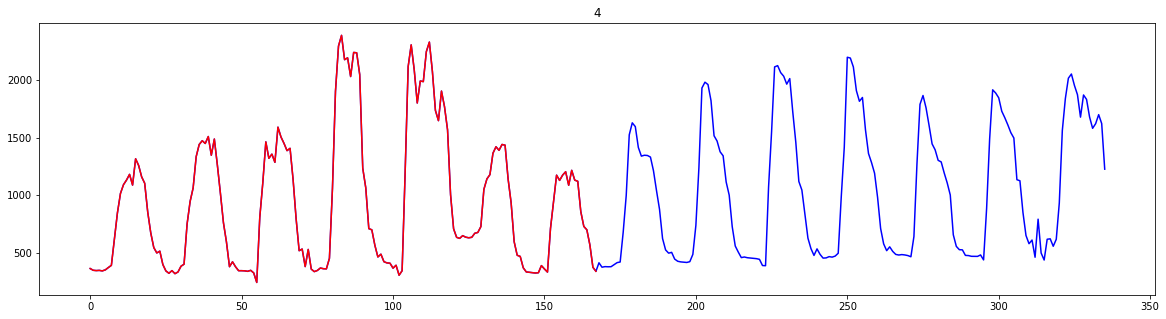

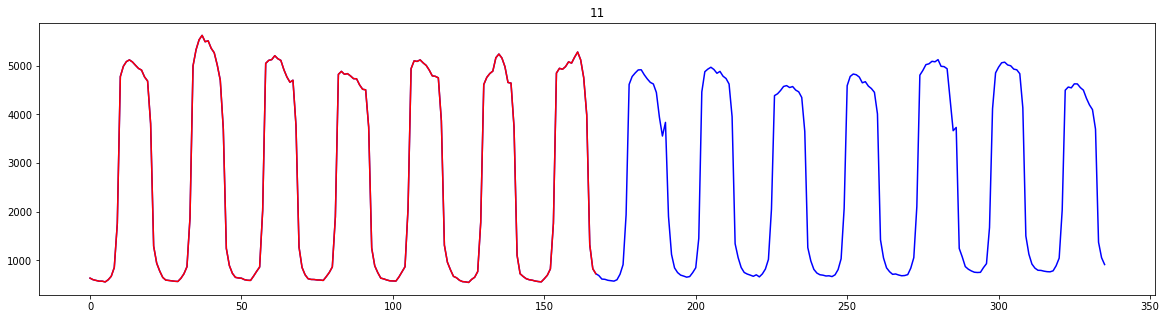

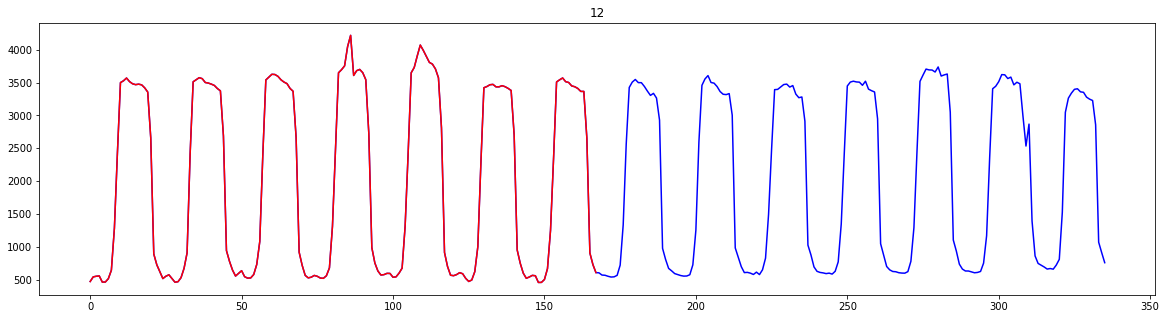

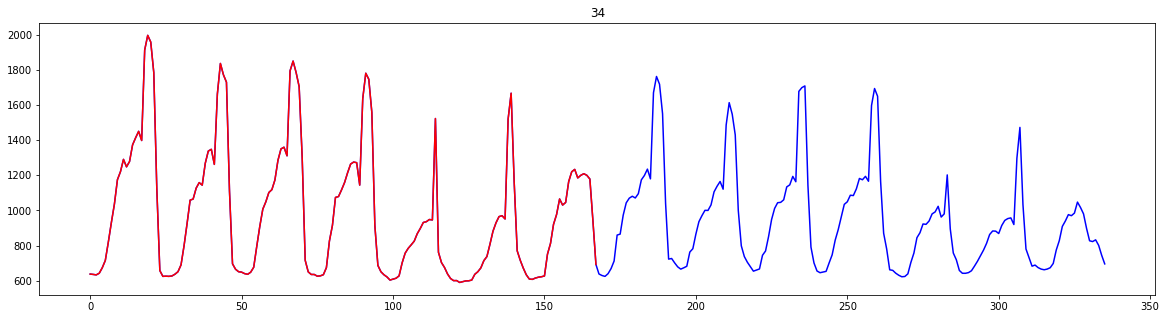

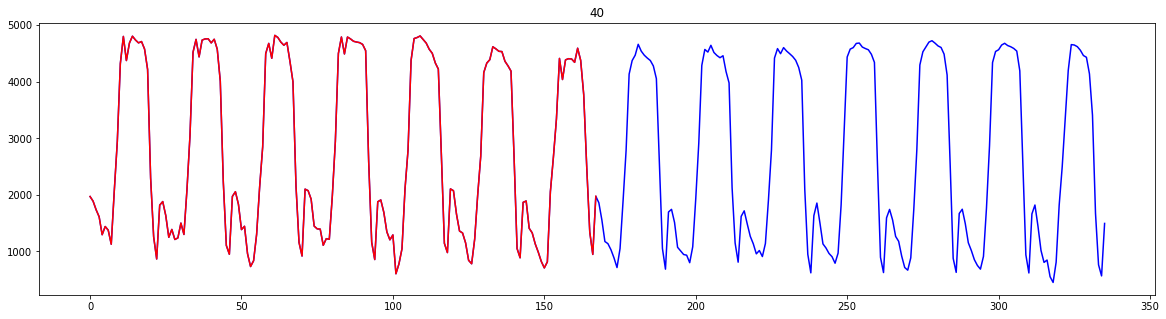

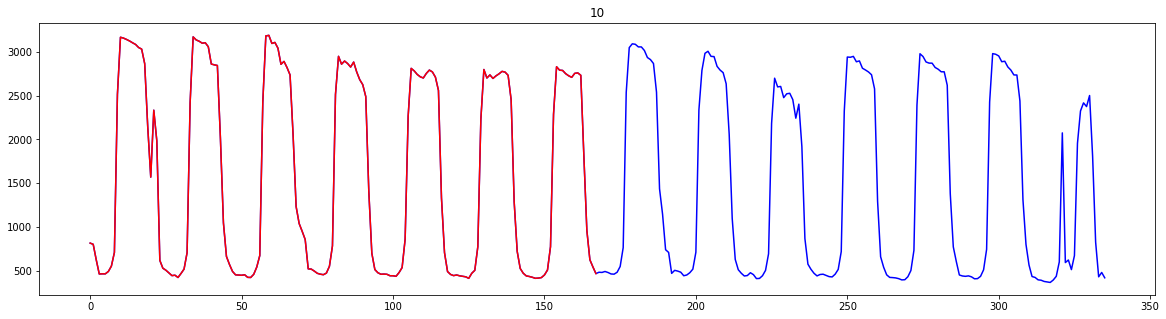

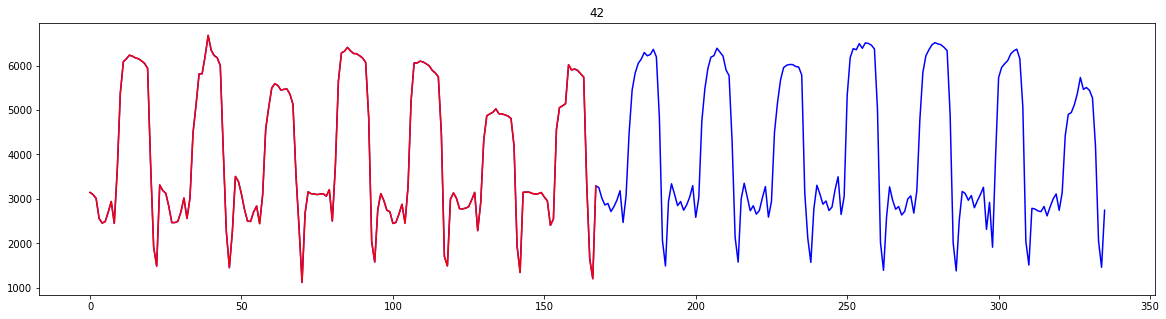

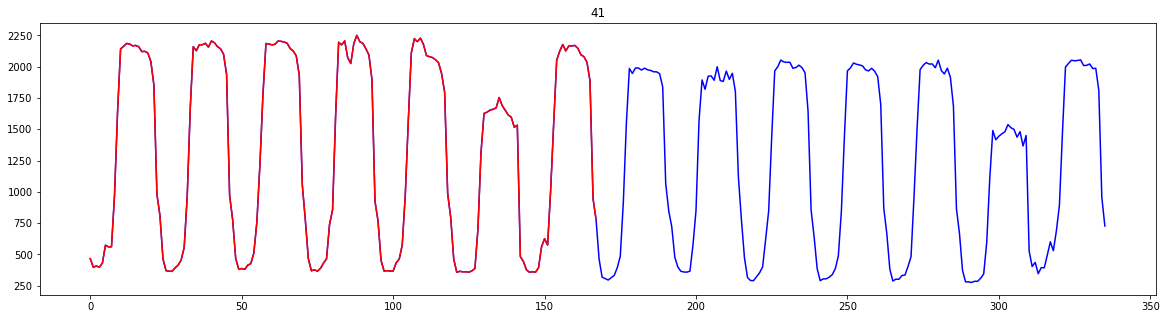

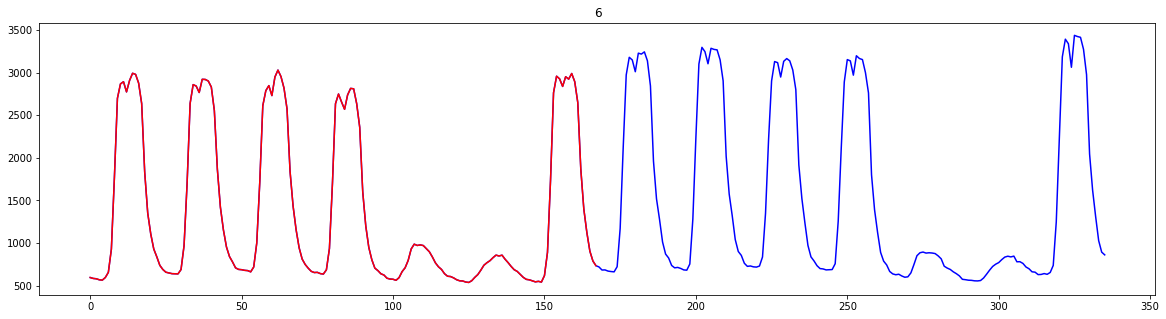

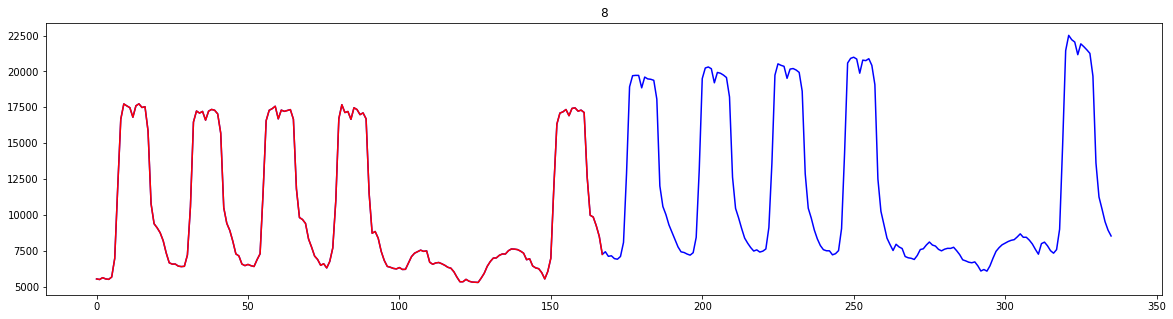

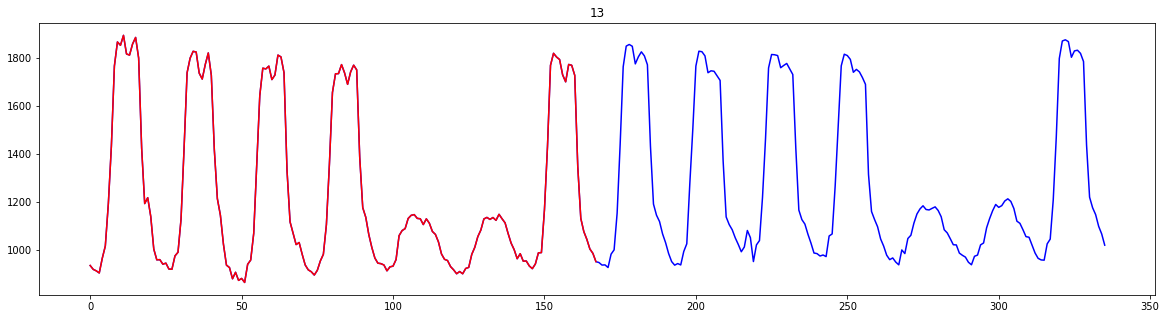

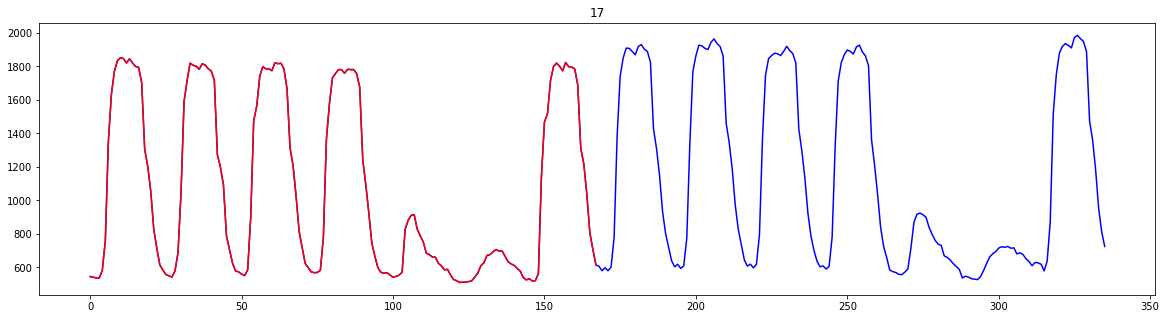

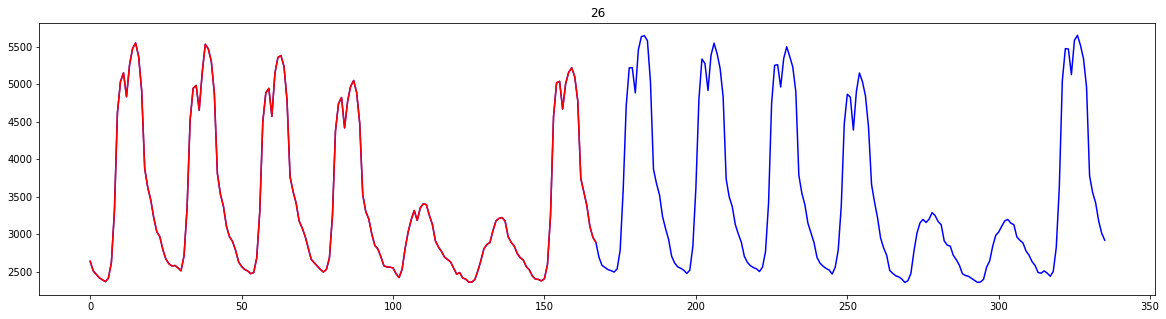

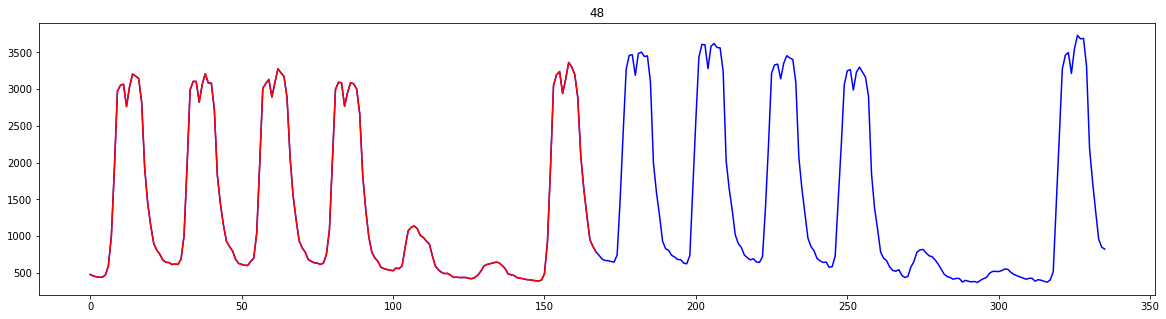

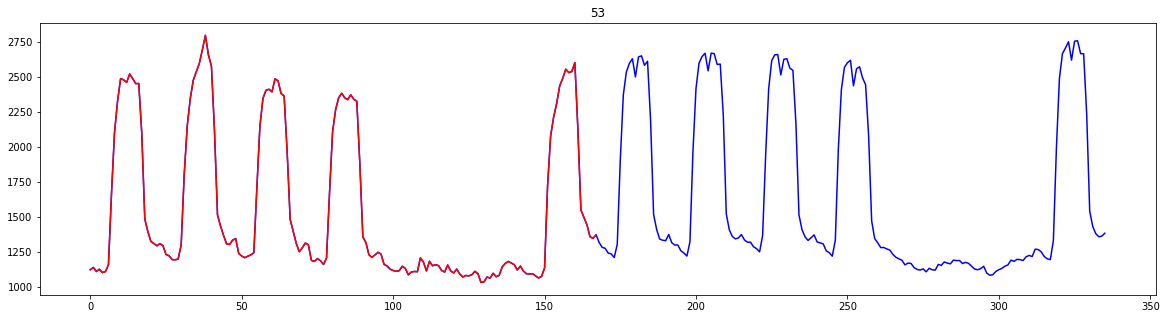

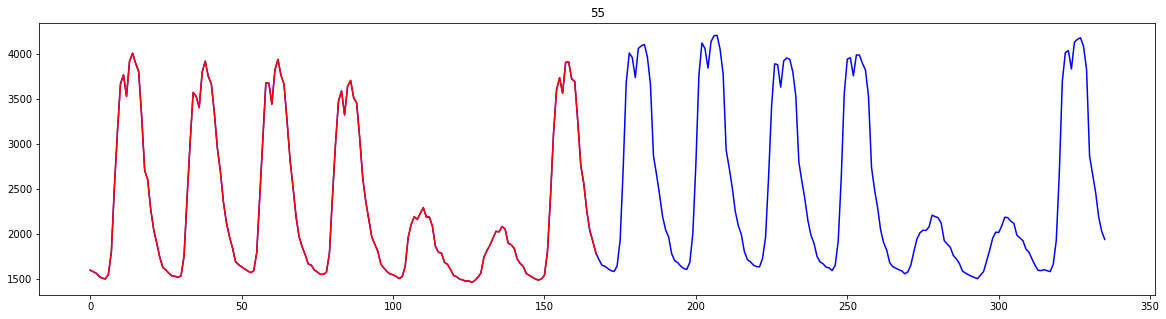

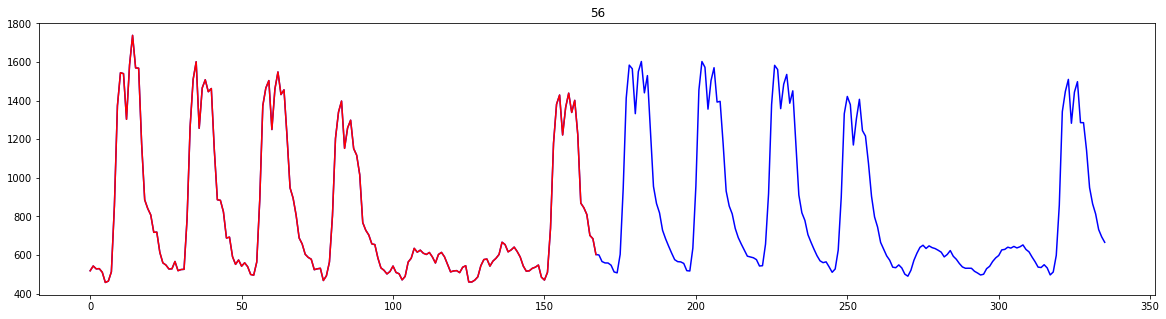

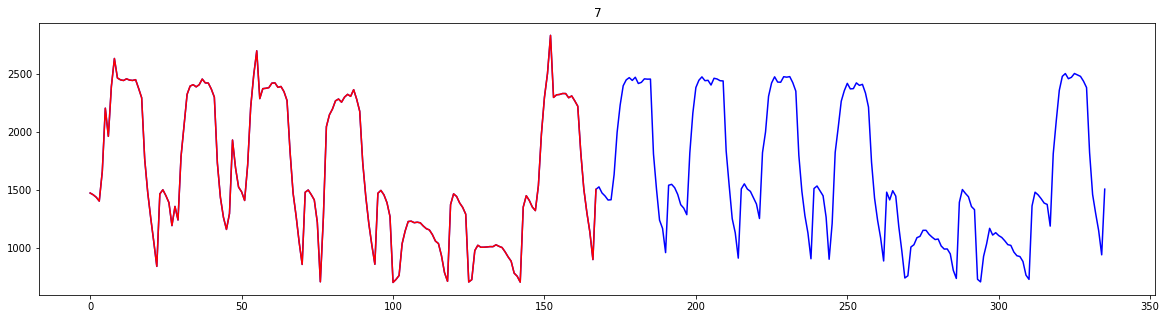

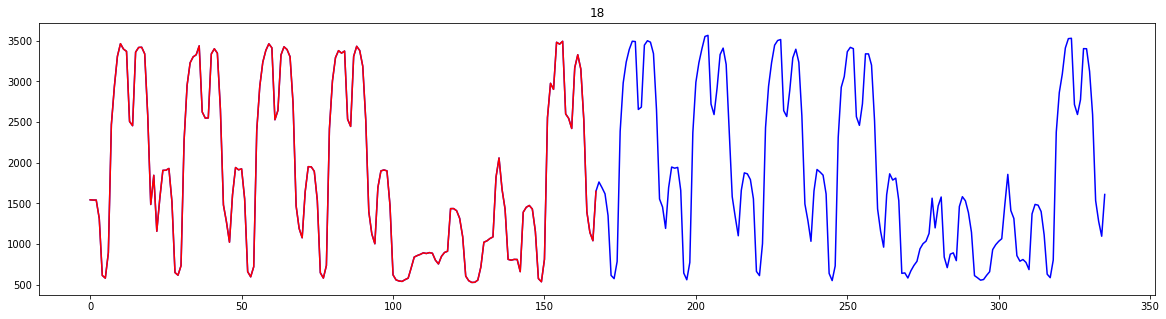

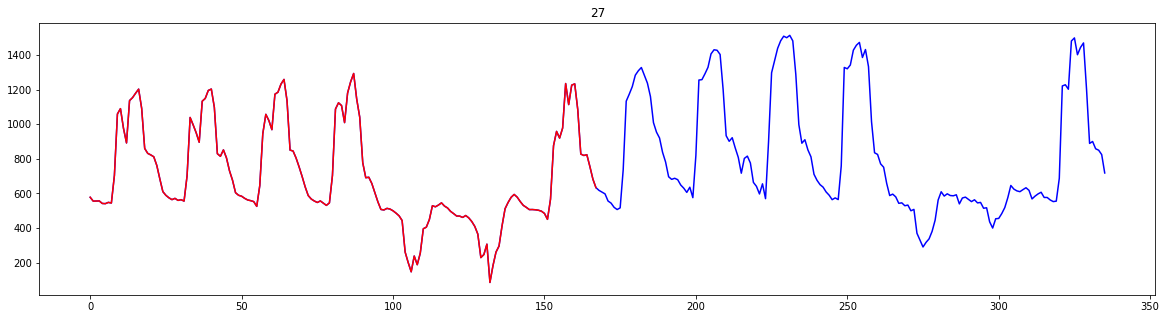

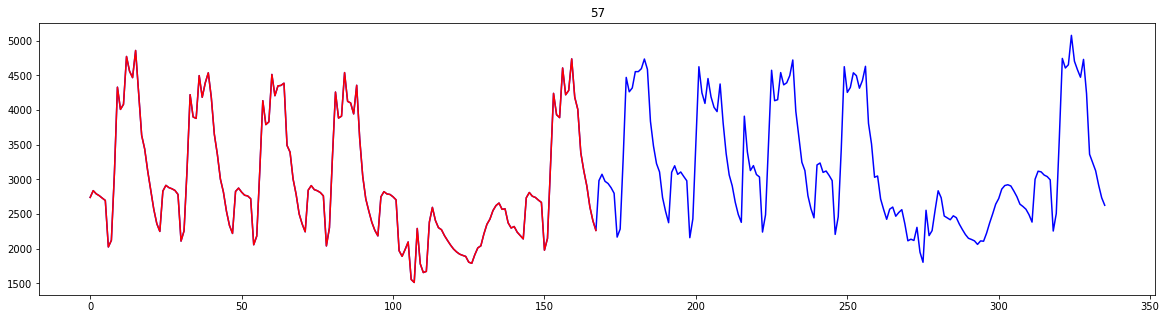

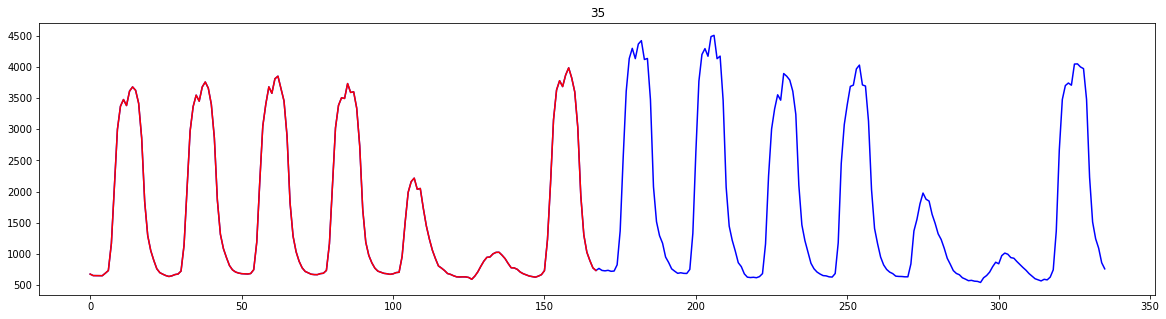

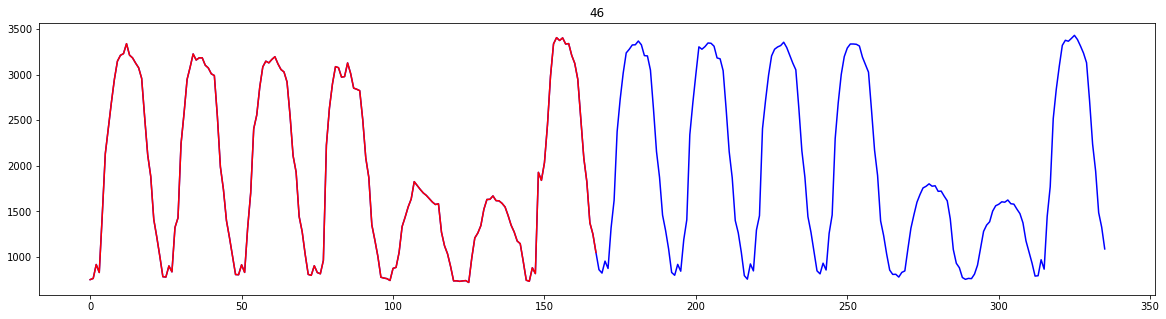

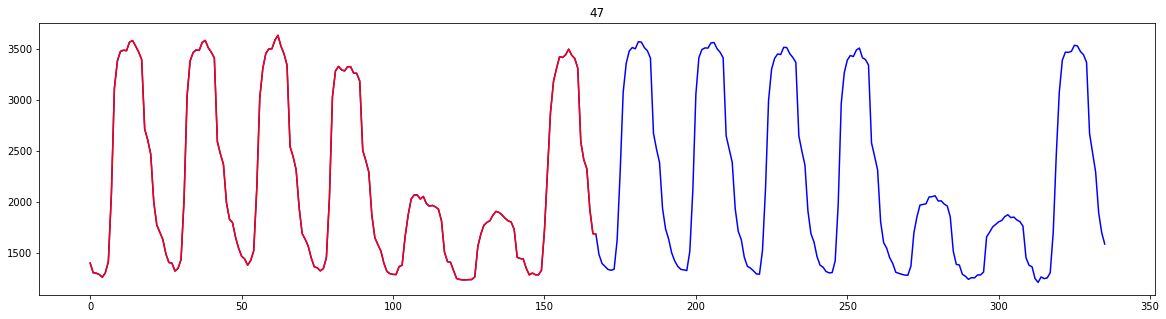

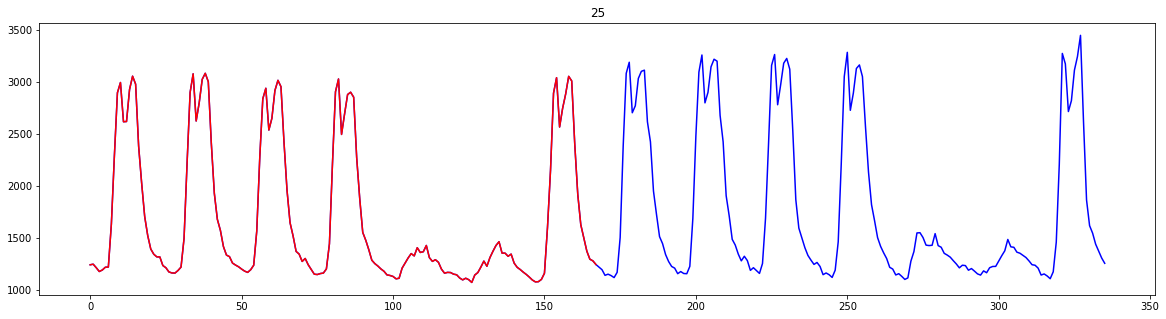

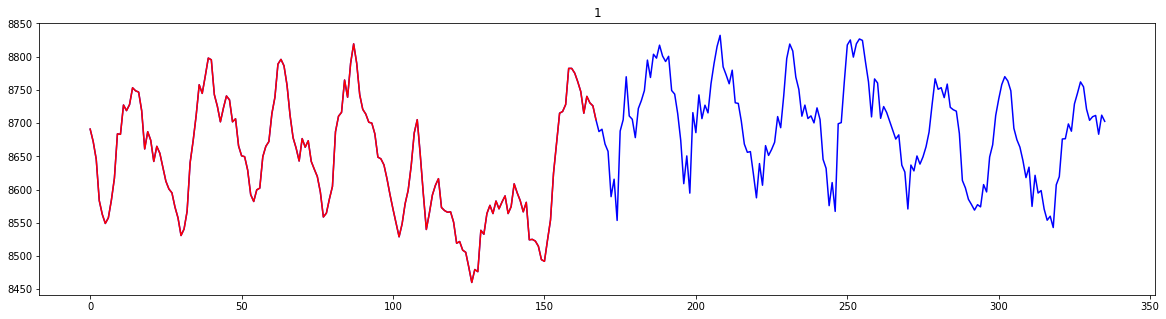

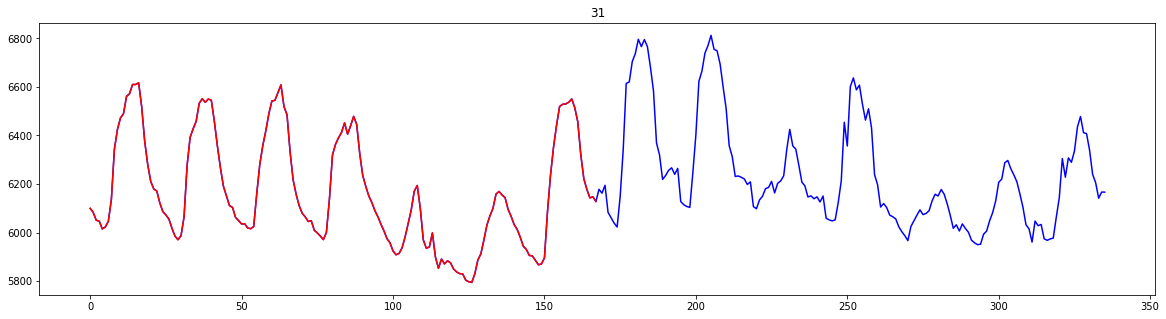

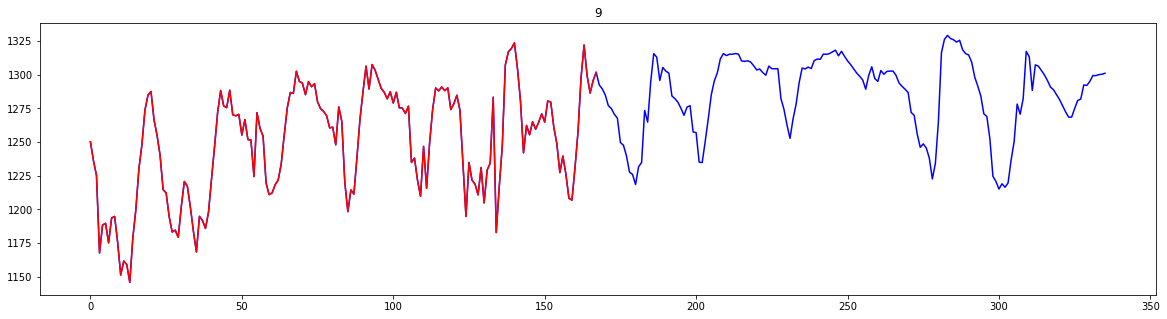

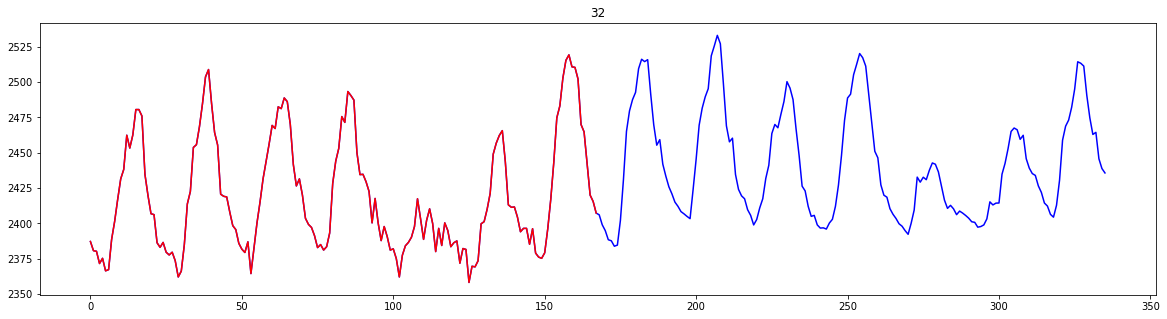

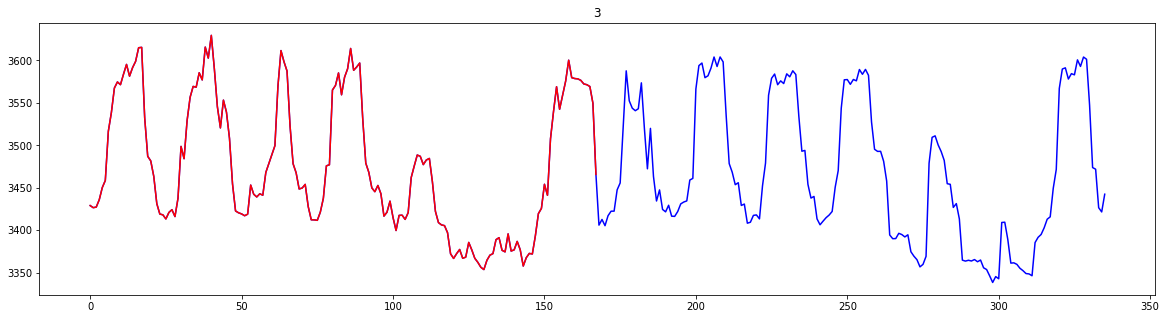

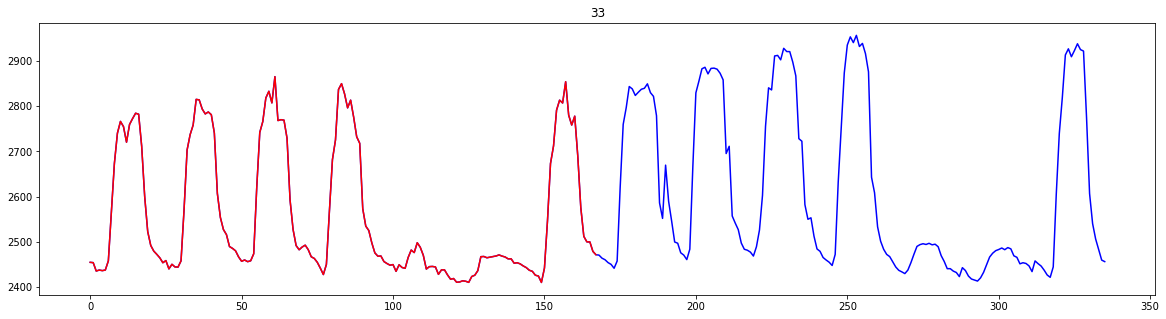

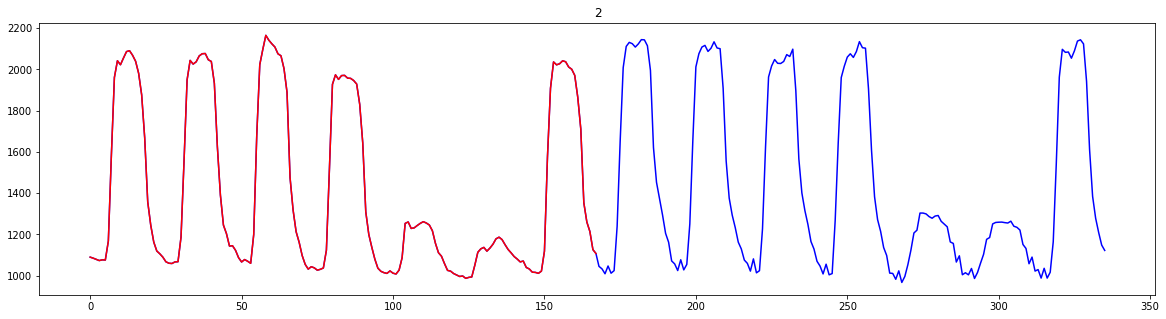

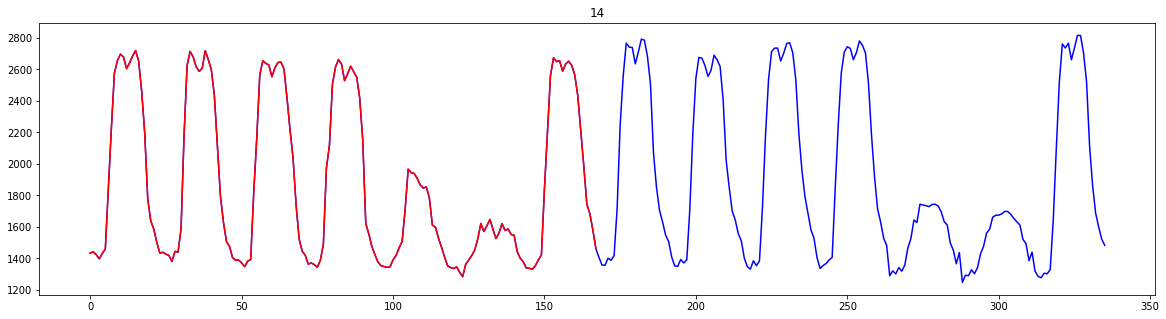

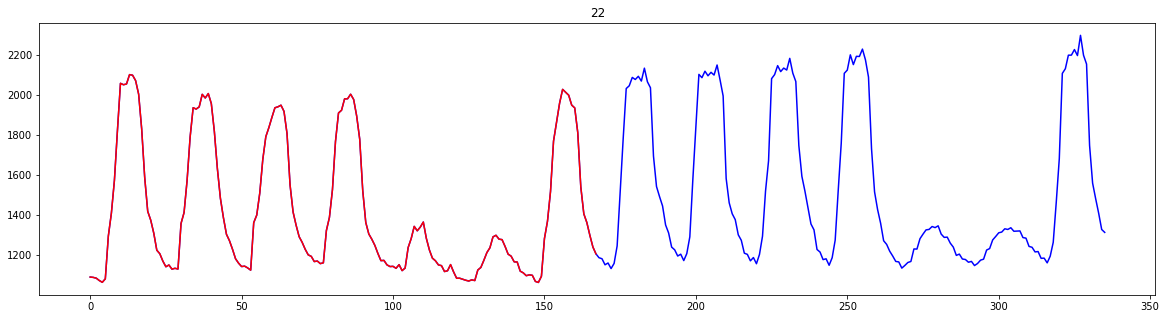

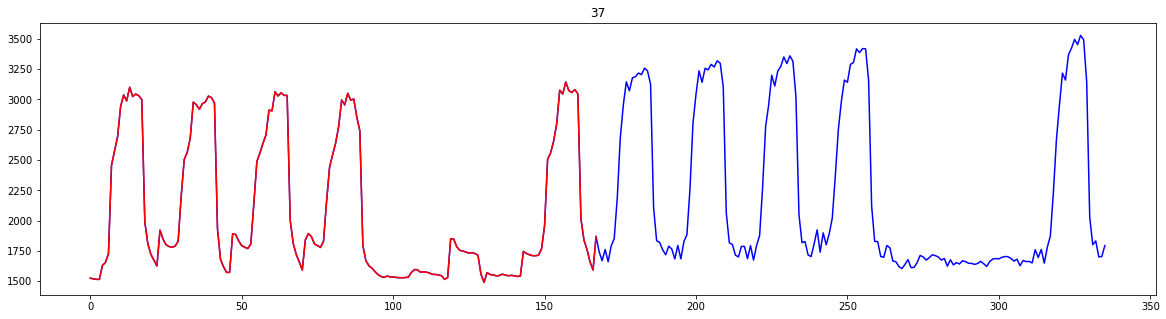

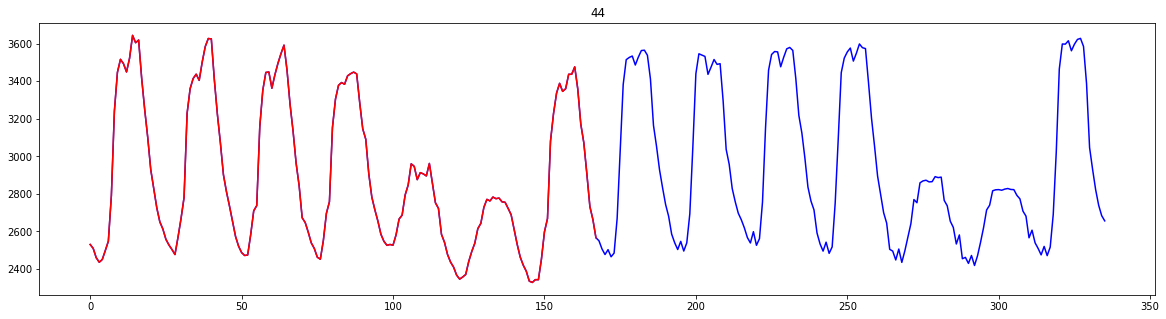

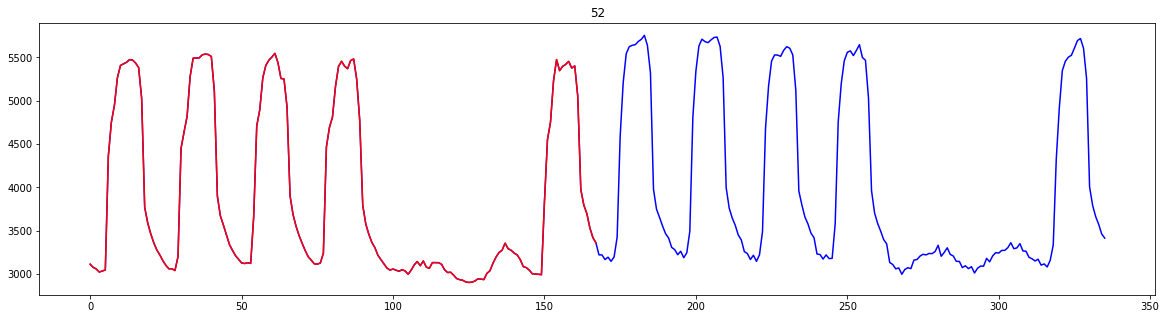

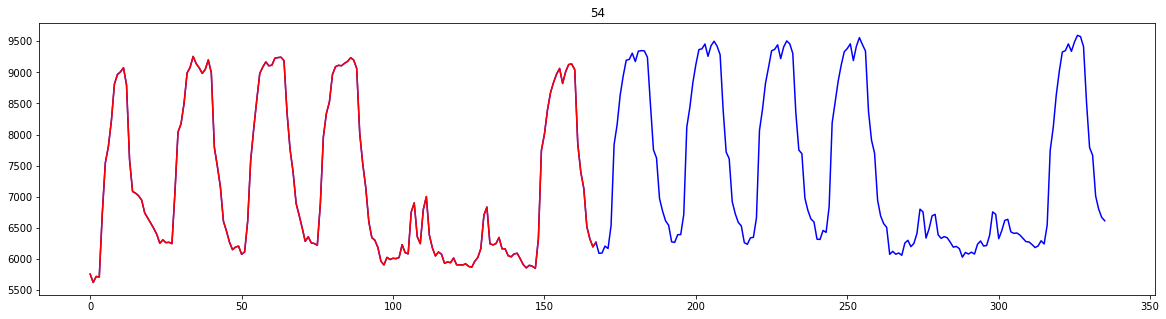

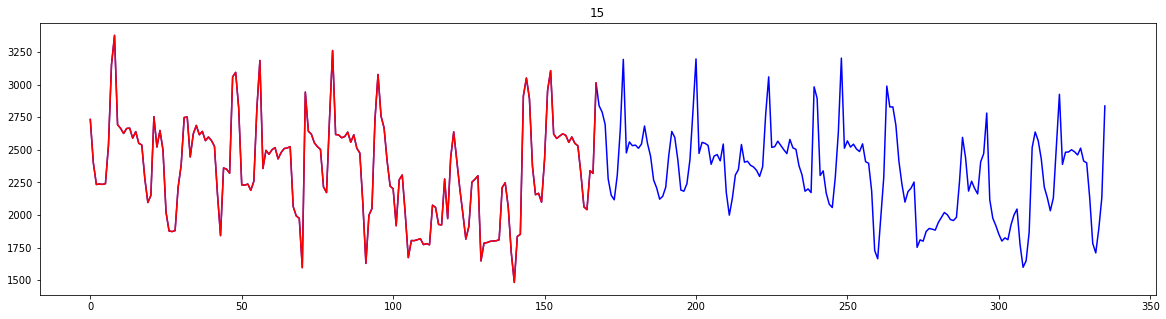

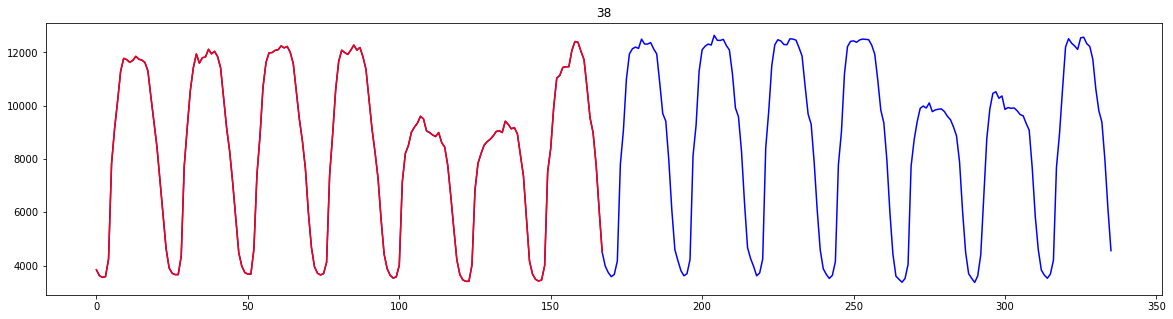

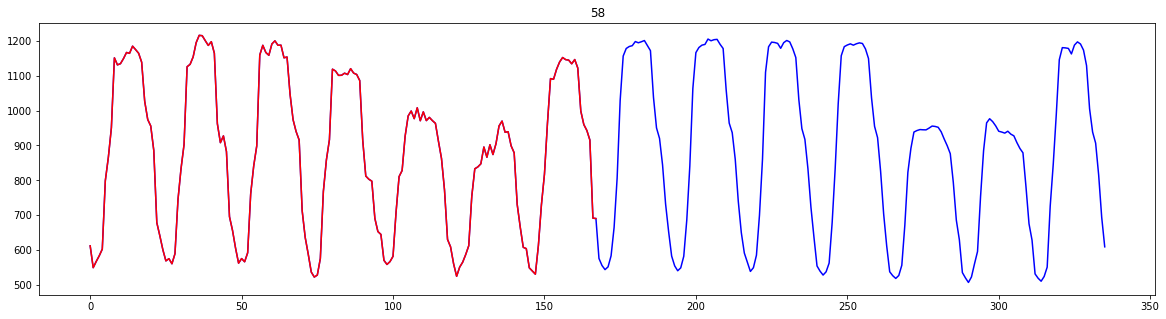

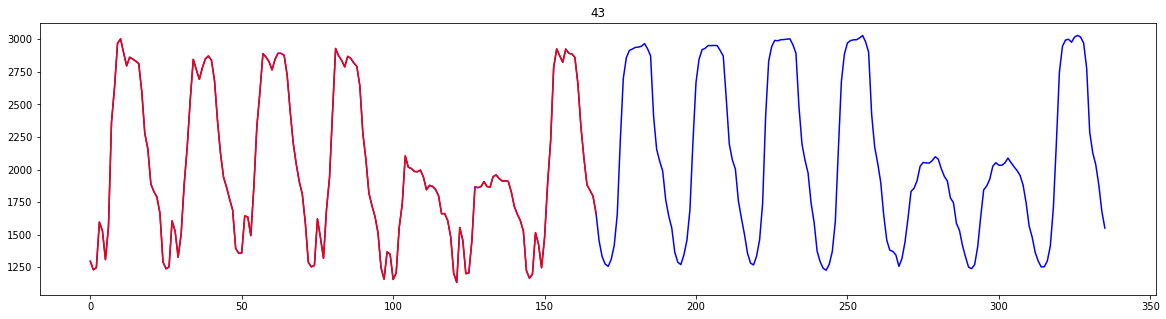

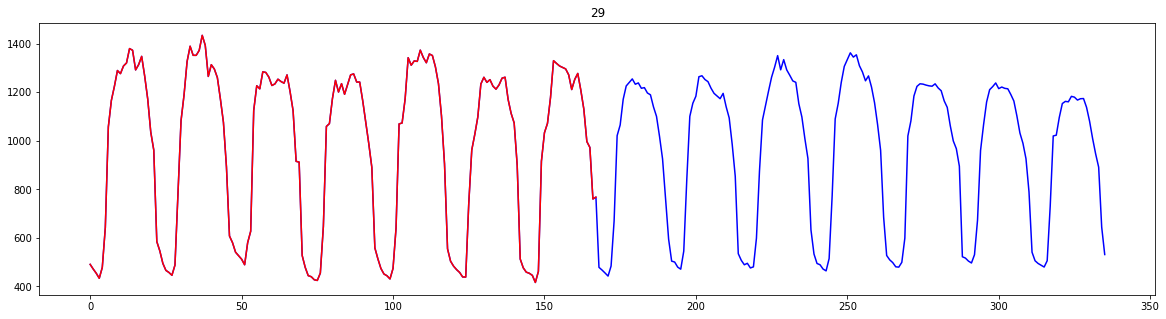

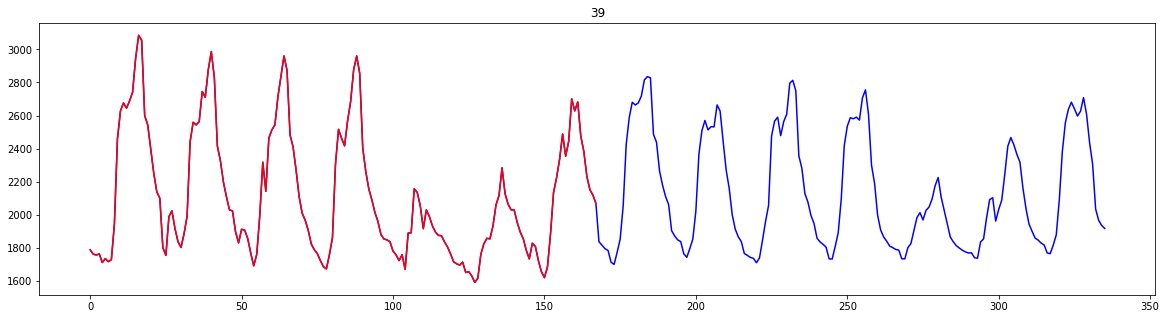

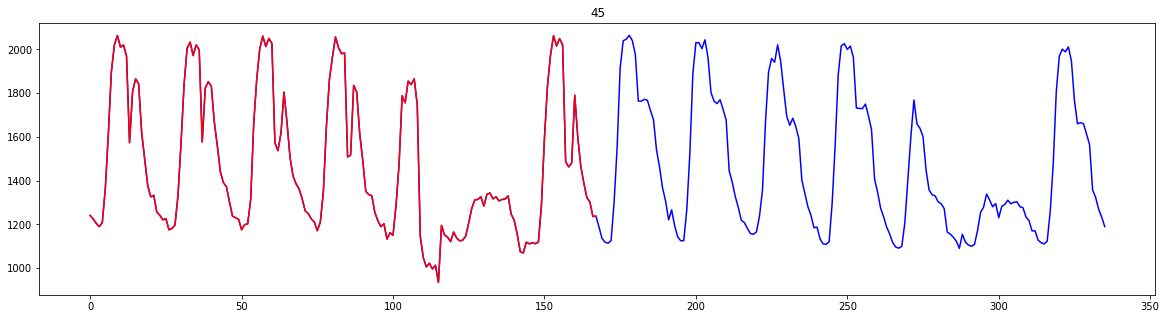

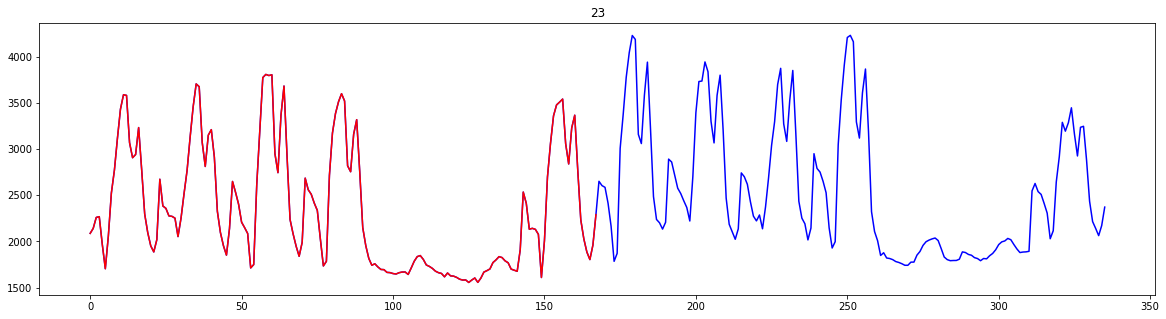

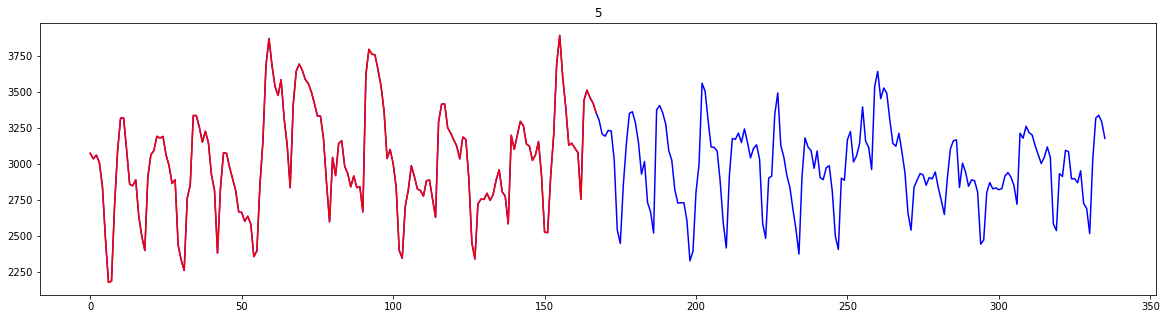

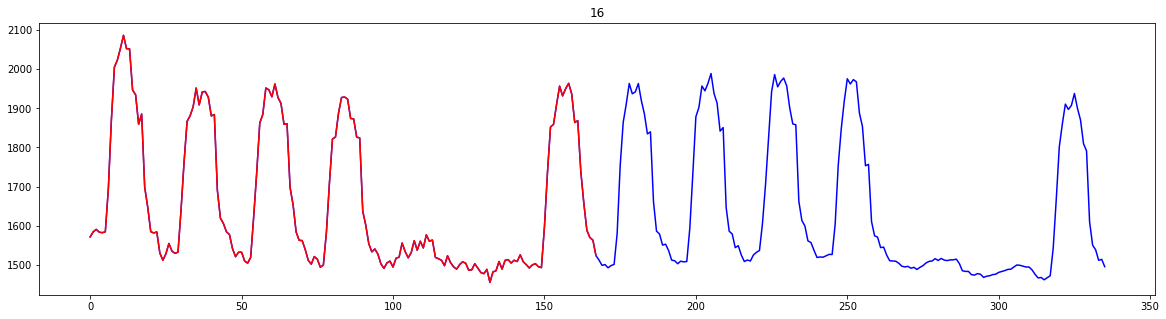

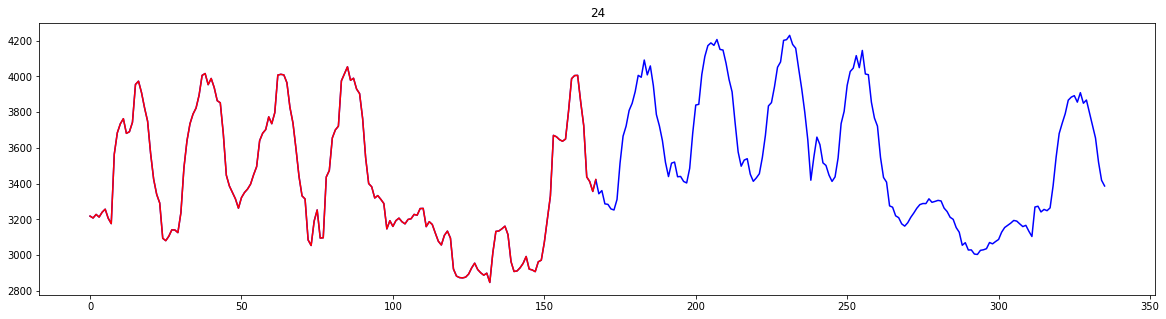

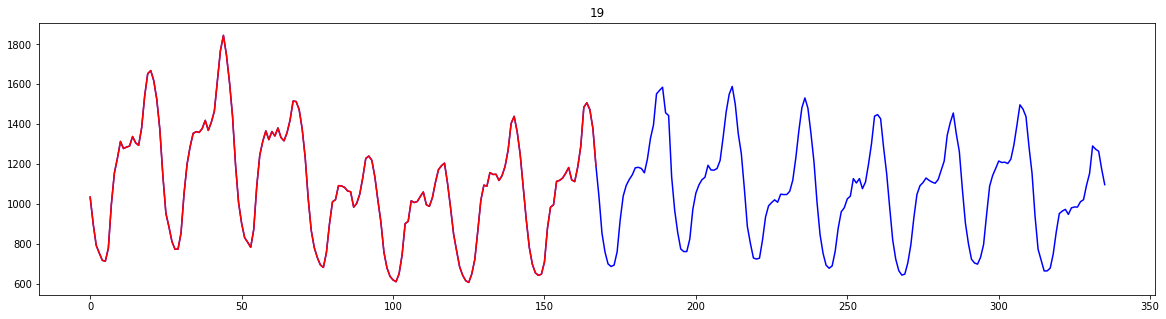

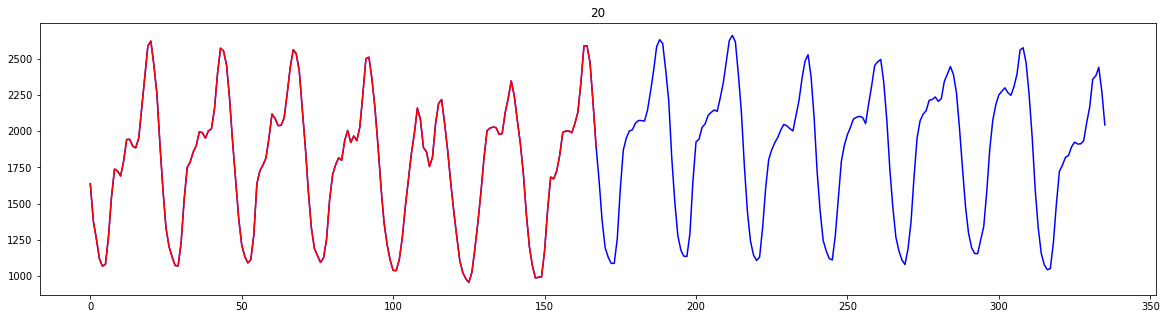

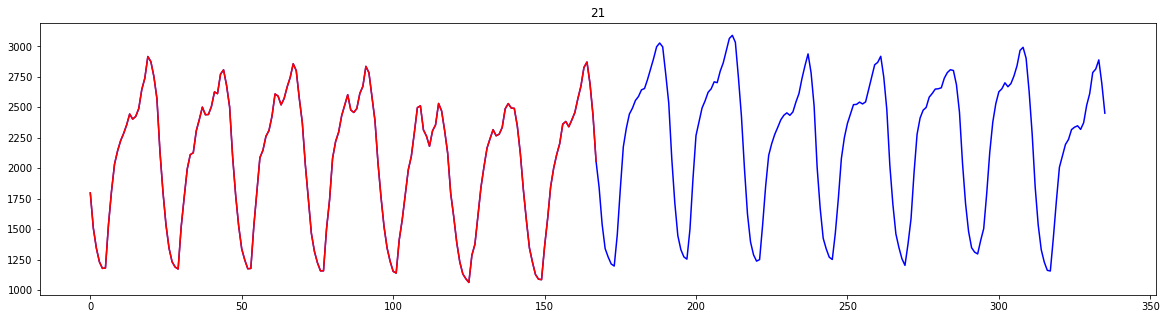

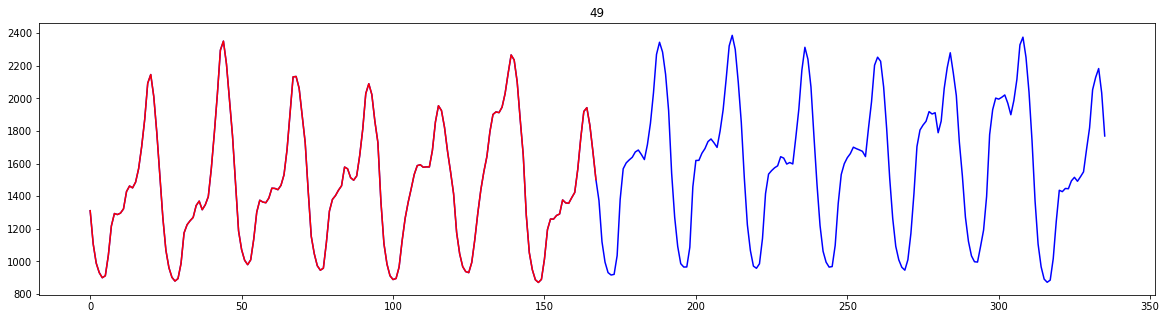

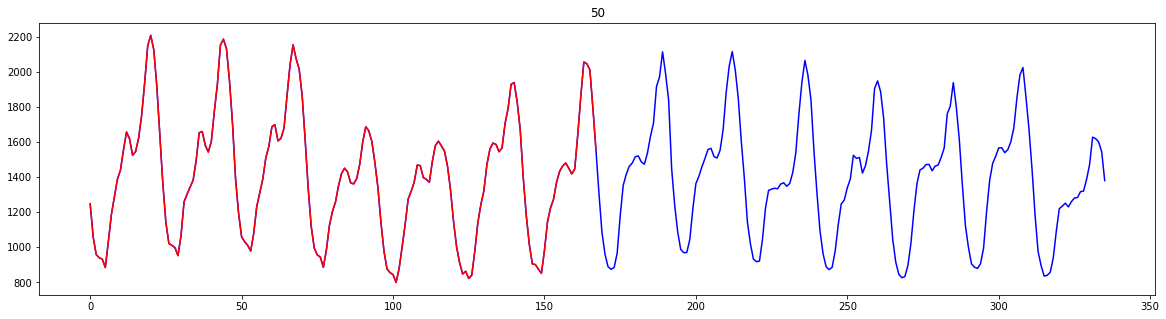

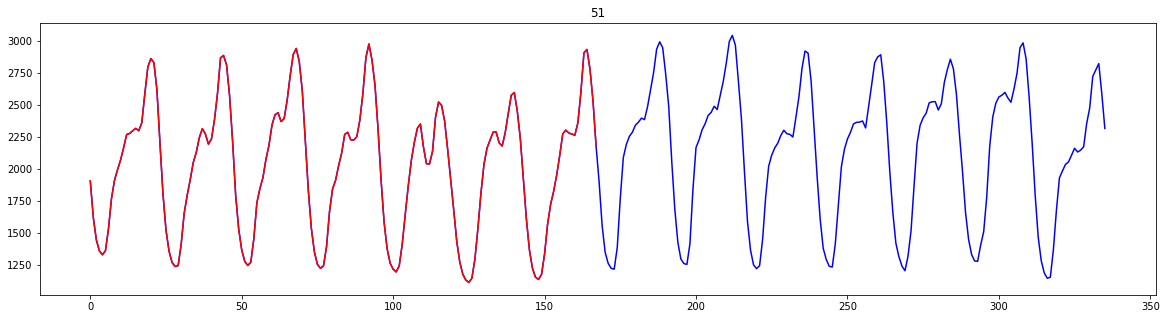

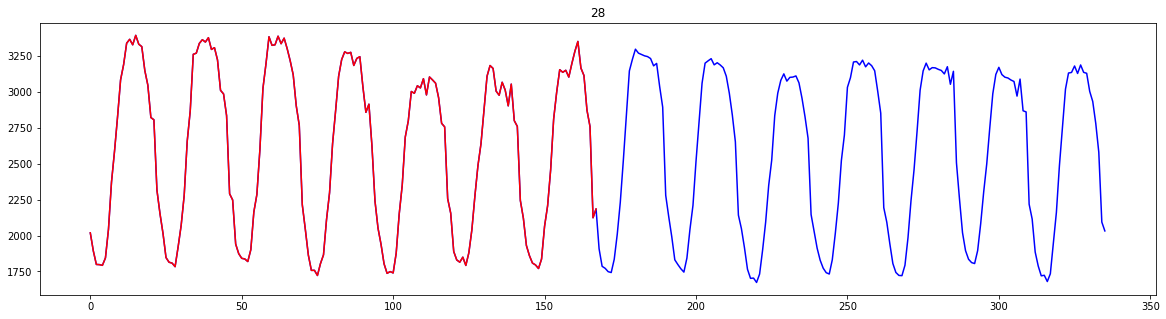

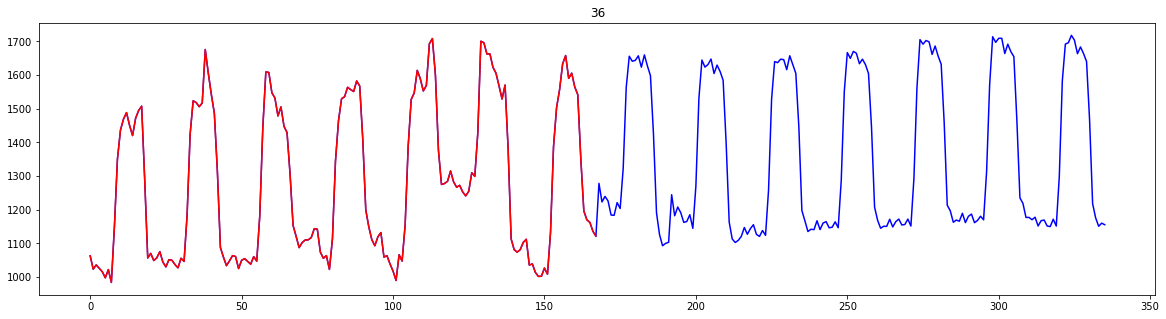

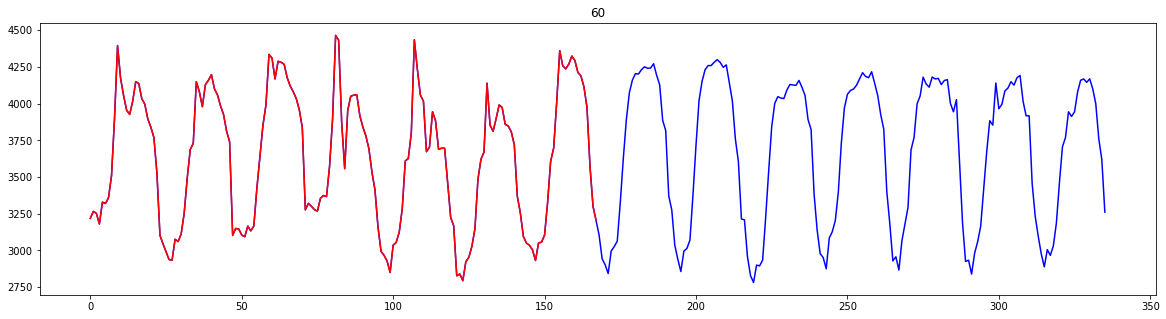

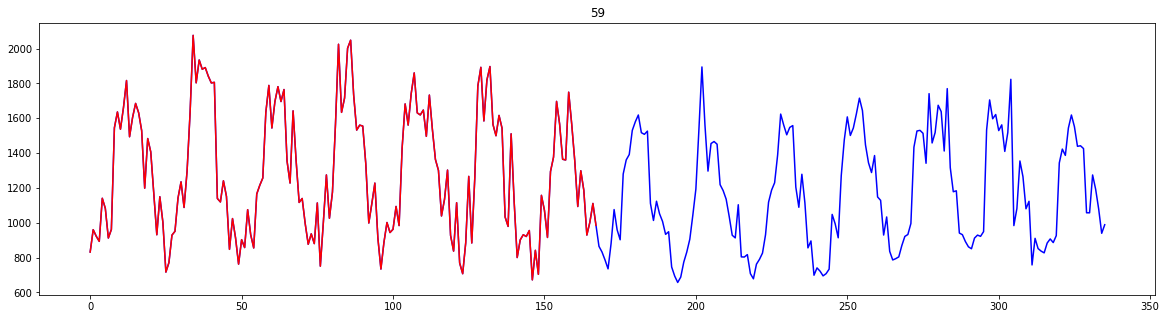

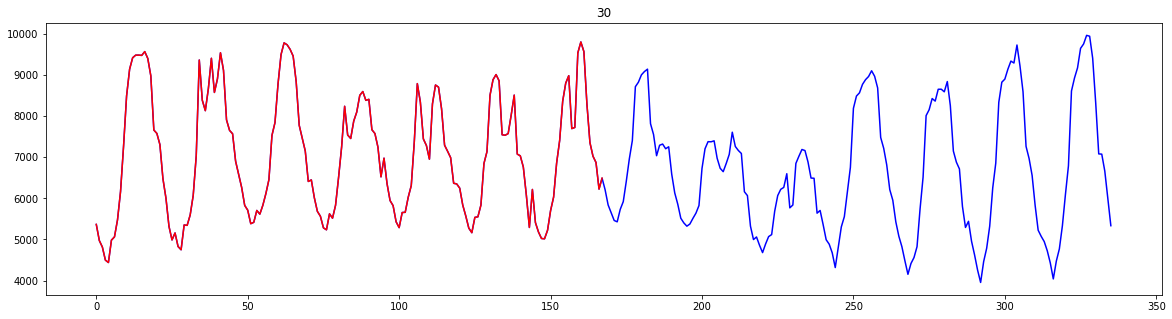

In [5]:
for i in range(len(model_paths)):
    now_dataframe = dataframe
    now_dataframe['num'] = now_dataframe['num'].apply(str)
    now_dataframe['energy_group'] = now_dataframe['energy_group'].apply(str)
    now_dataframe['Week'] = now_dataframe['Week'].apply(str)
    now_dataframe['24Hour'] = now_dataframe['24Hour'].apply(str)
    now_dataframe['holiday'] = now_dataframe['holiday'].apply(str)
    now_dataframe['Weekend'] = now_dataframe['Weekend'].apply(str)
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    for building in group[i]:
        now_building_dataframe = now_dataframe.loc[now_dataframe["num"] == str(building)].copy()
        now_building_dataframe = now_building_dataframe[(-168*2):]

        original = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()  
        real_prediction = []
        real_prediction_time = now_building_dataframe.iloc[168:]["date_time"].tolist()[:]

        total_cycle = ((len(now_building_dataframe) - input_length - output_length) // output_length) + 1

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]

            prediction.extend(raw_predictions)
            real_prediction.extend(raw_predictions)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        if show_graph:
            plt.rcParams["figure.figsize"] = (20,5)
            fig = plt.figure()
            graph = fig.add_subplot(1, 1, 1)
            graph.set_title(f"{building}")
            graph.plot(prediction, color='blue')
            graph.plot(original[:(168+48)], color='red')
            plt.show()


        # 1 2020-08-25 00
        real_prediction = real_prediction[:]
        real_prediction_bag.append([building,real_prediction])

        result = pd.DataFrame({"num_date_time" : ["padding"], "answer" : [999]})
        for k in range(len(real_prediction)):
            temp = pd.DataFrame({"num_date_time" : [f"{building} {real_prediction_time[k][:-6]}"], "answer" : [real_prediction[k]]})
            result = result.append(temp, ignore_index=True)
        result = result.drop(0,axis=0)

        all_result[building-1].append(result)

In [6]:
if result_save:

    complete_result = all_result[0][0]

    for i in range(1,60):
        complete_result = complete_result.append(all_result[i][0], ignore_index=True)

    complete_result.to_csv(f"Result/submission.csv", mode='w', index = False)

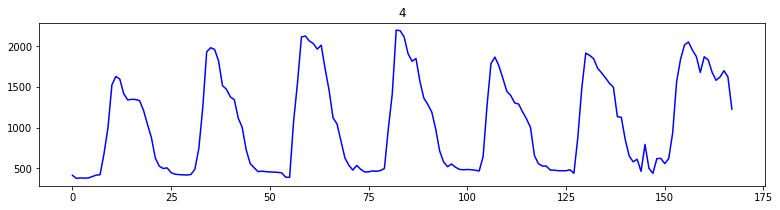

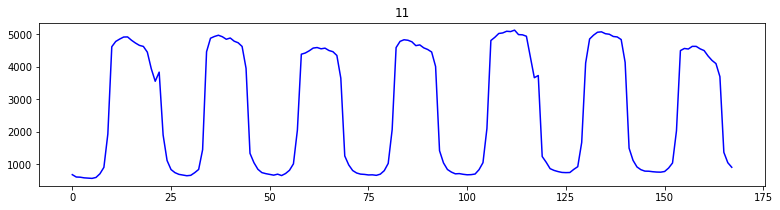

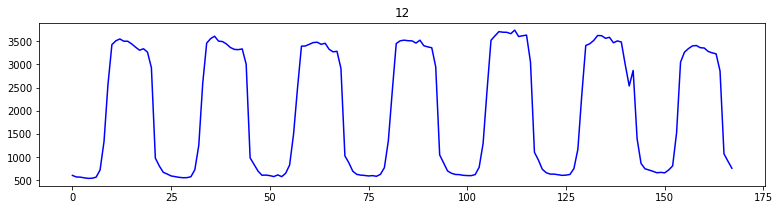

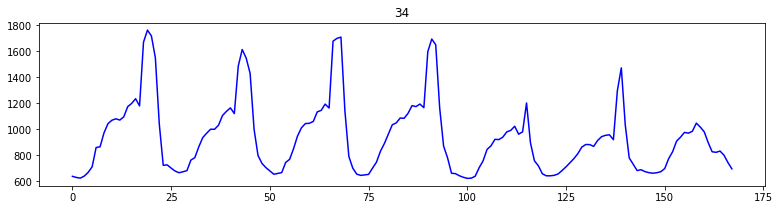

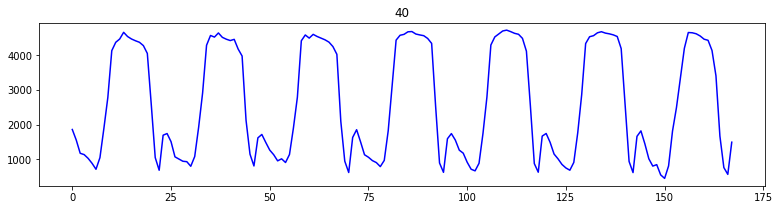

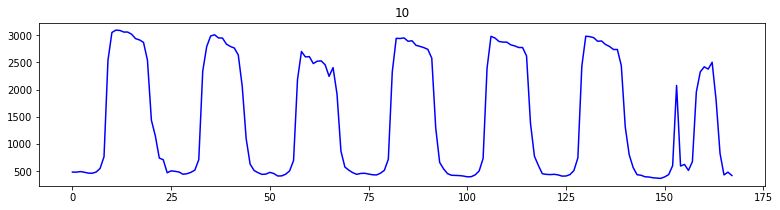

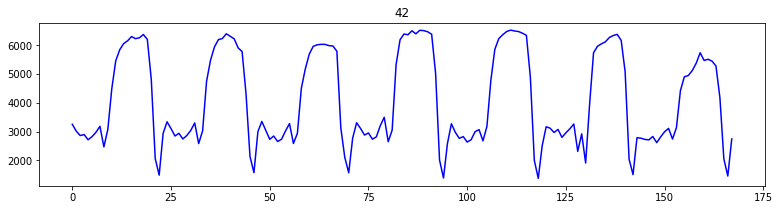

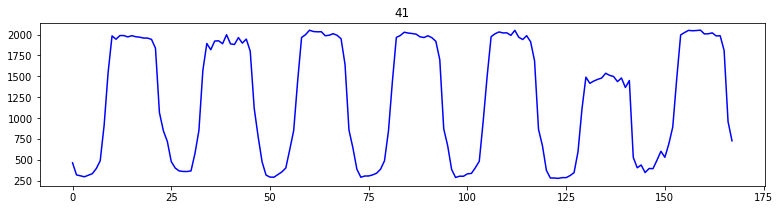

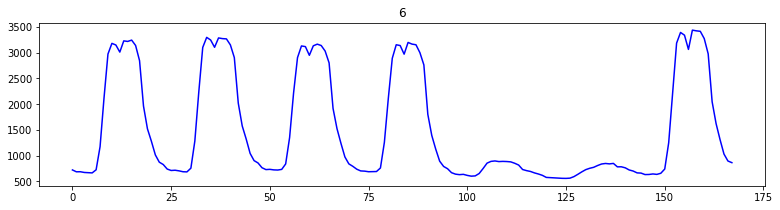

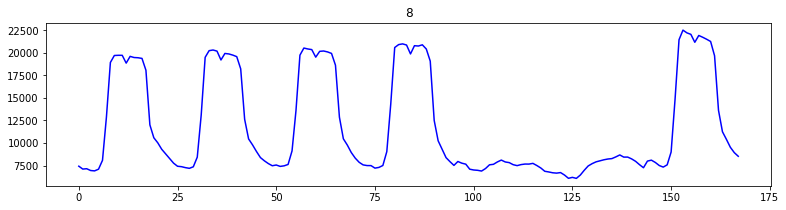

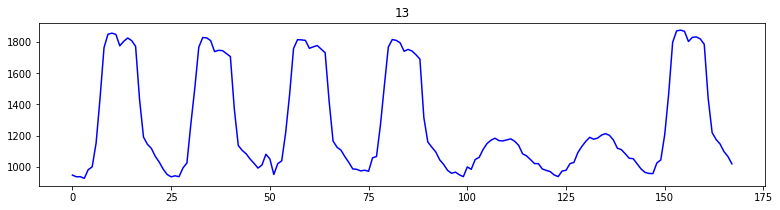

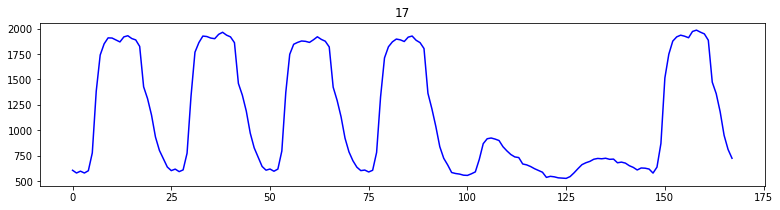

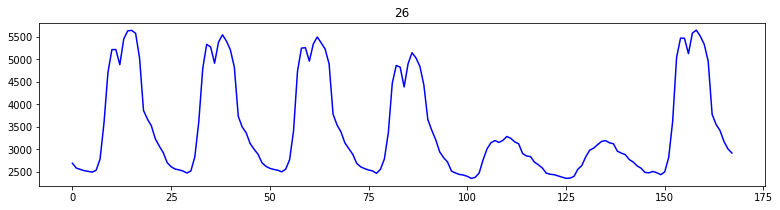

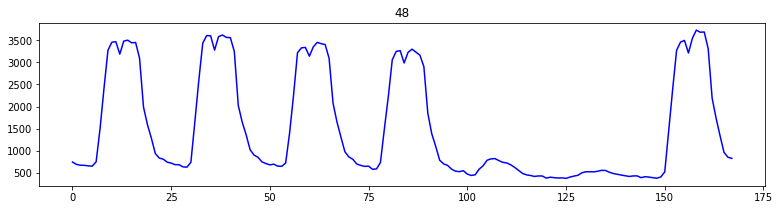

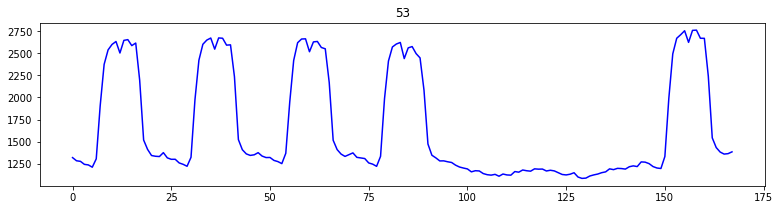

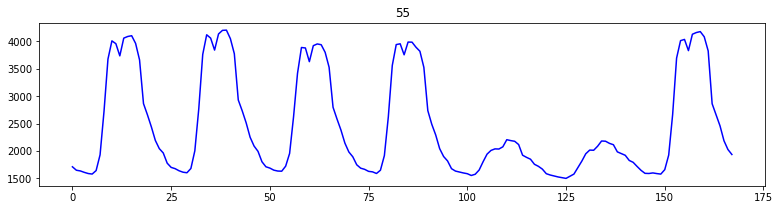

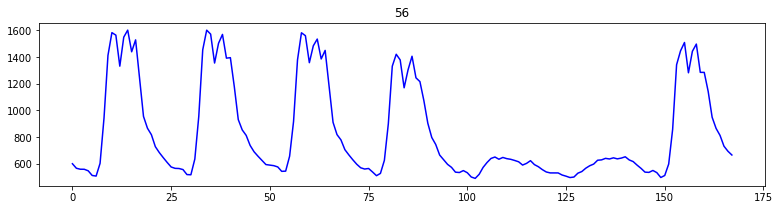

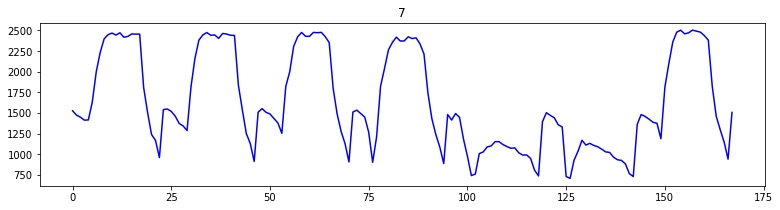

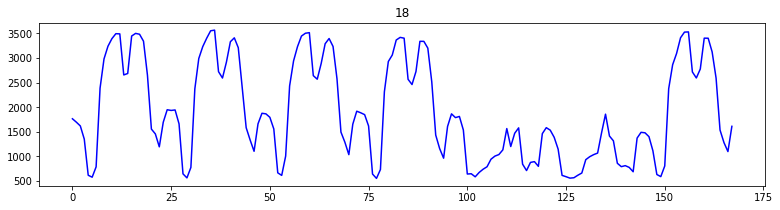

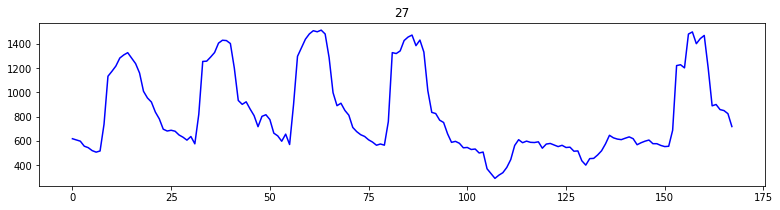

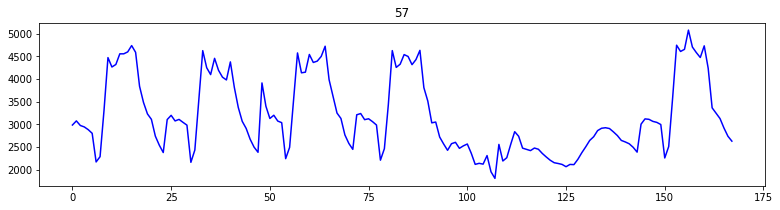

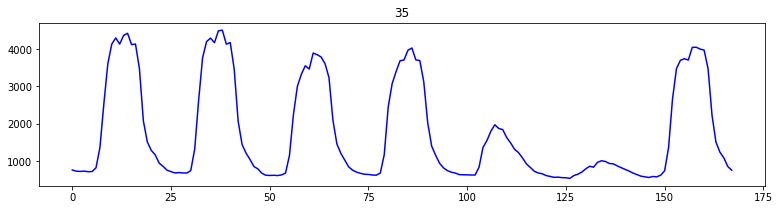

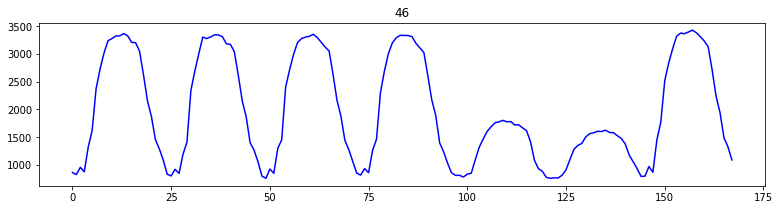

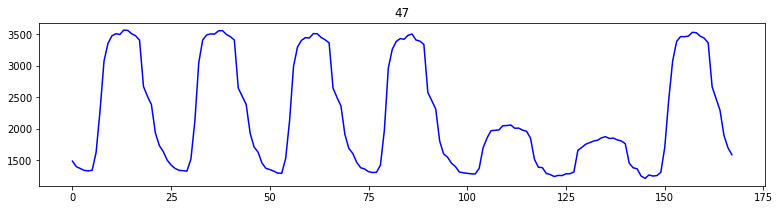

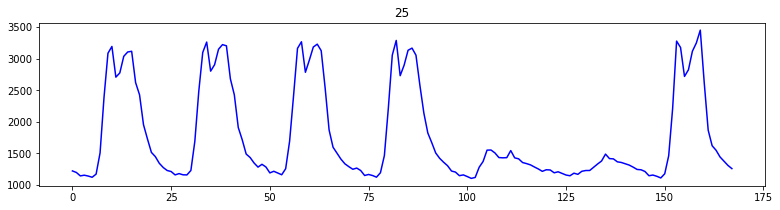

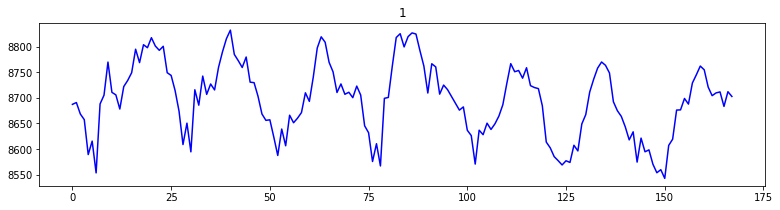

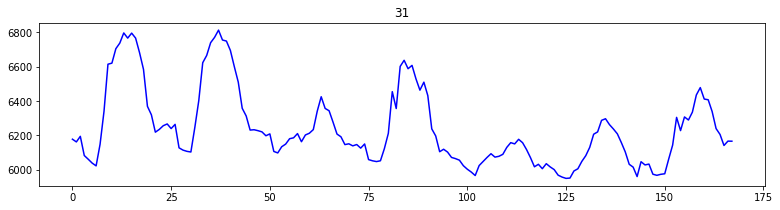

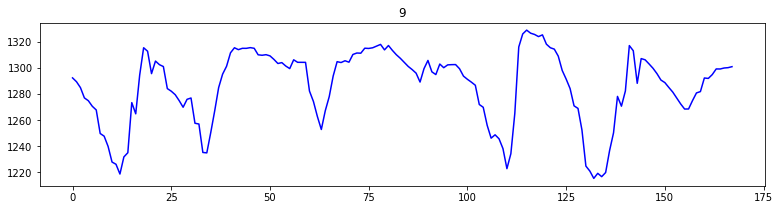

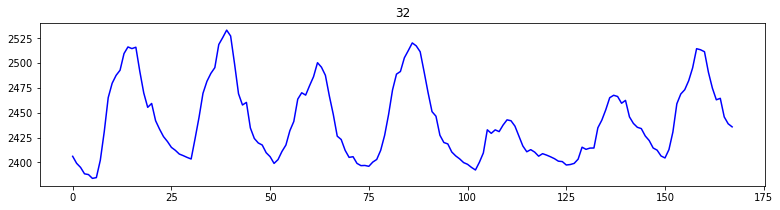

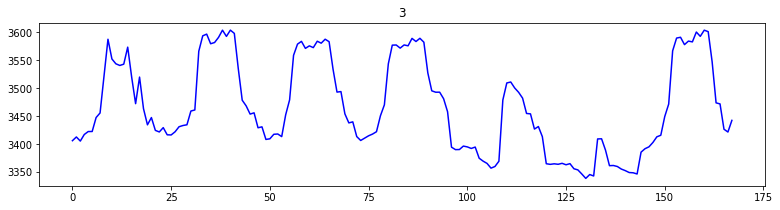

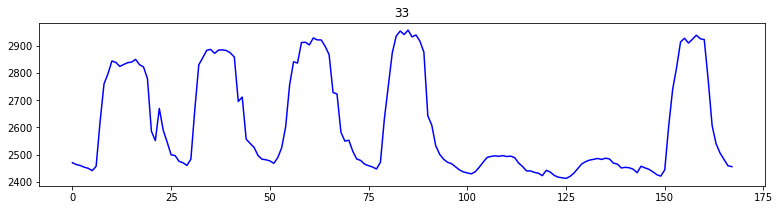

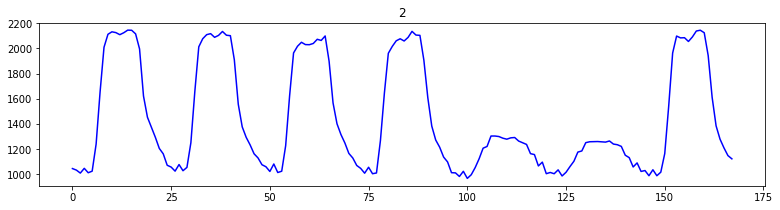

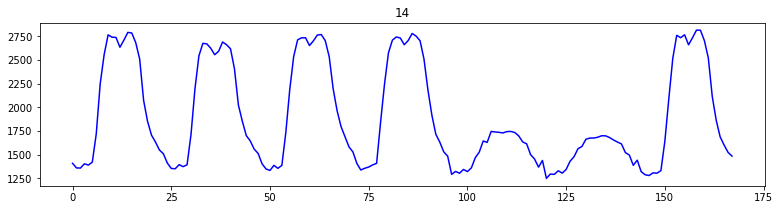

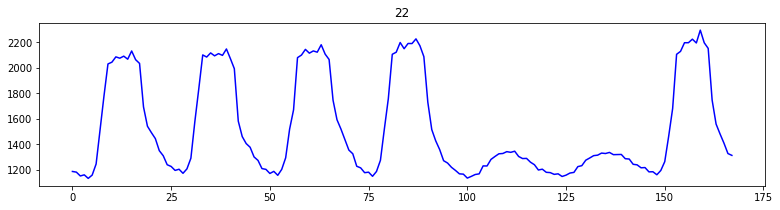

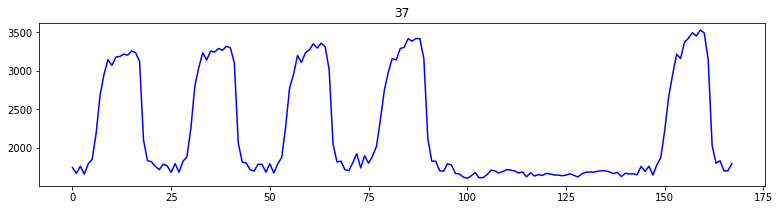

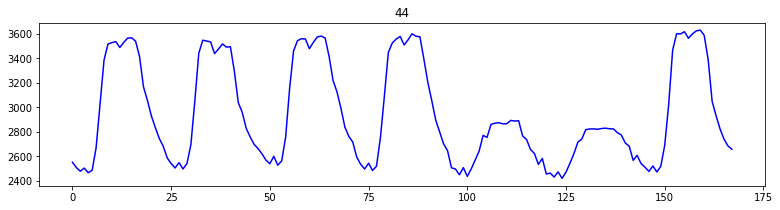

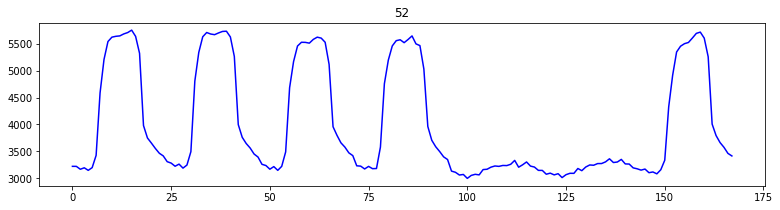

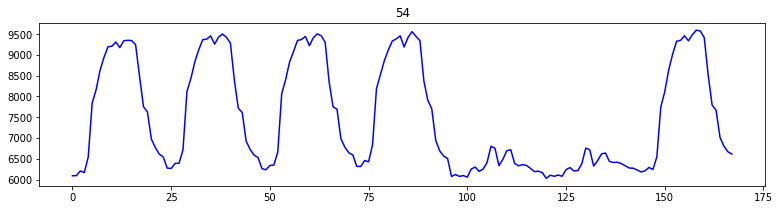

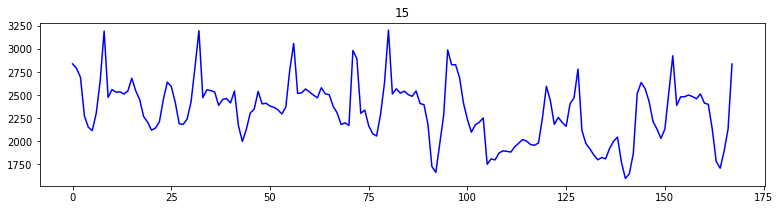

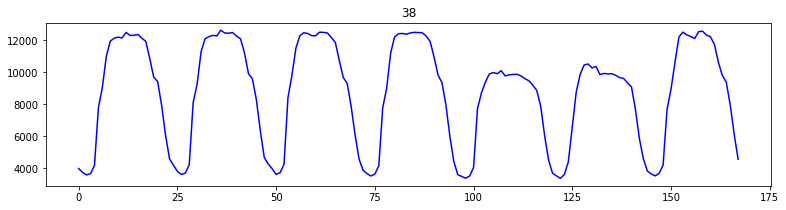

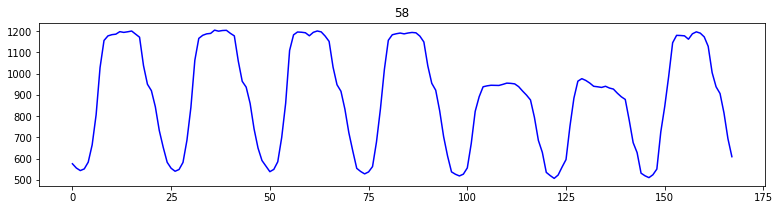

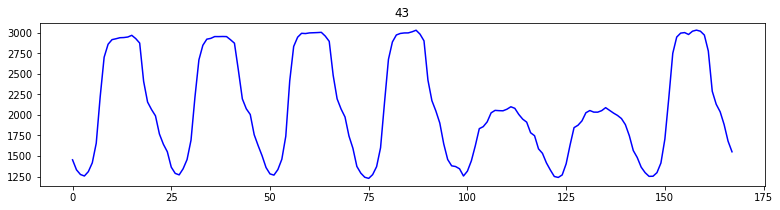

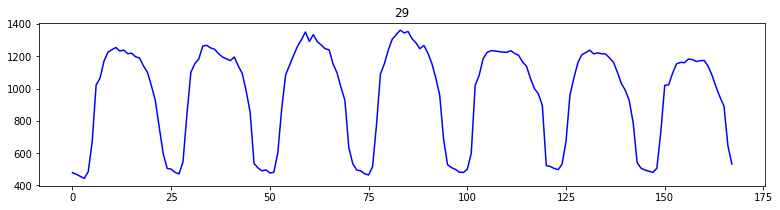

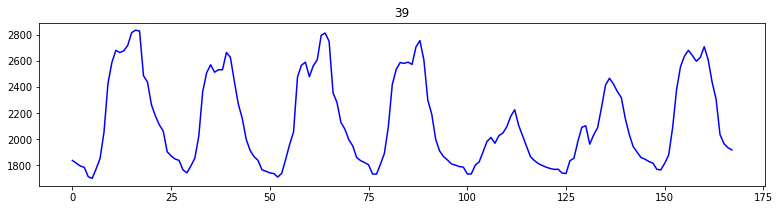

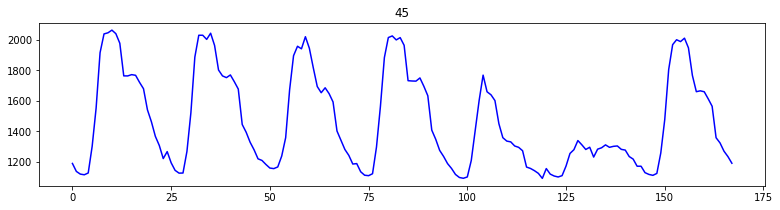

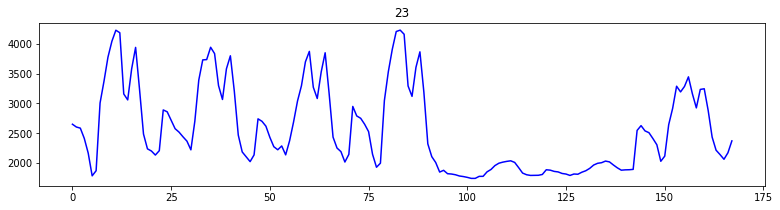

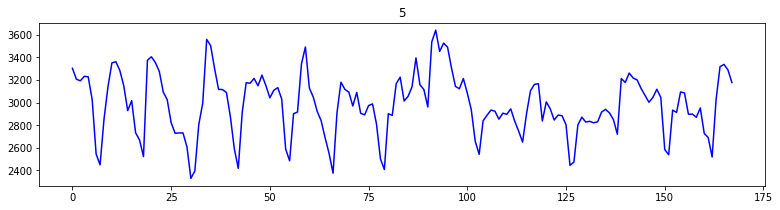

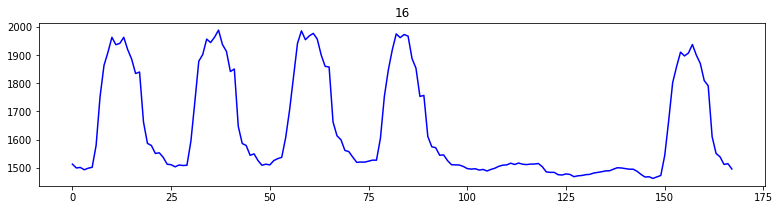

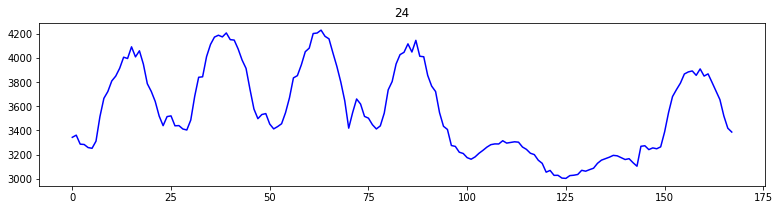

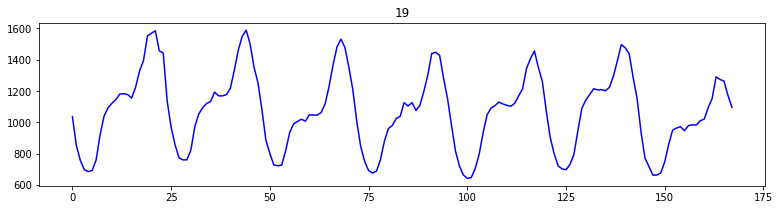

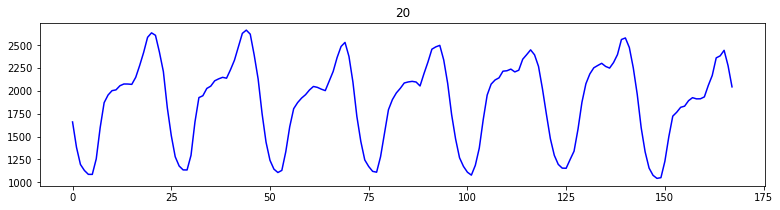

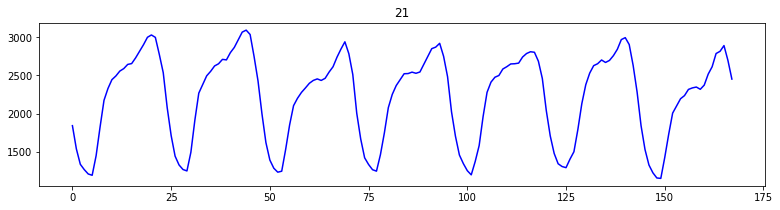

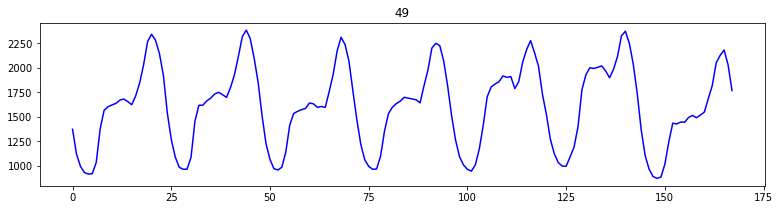

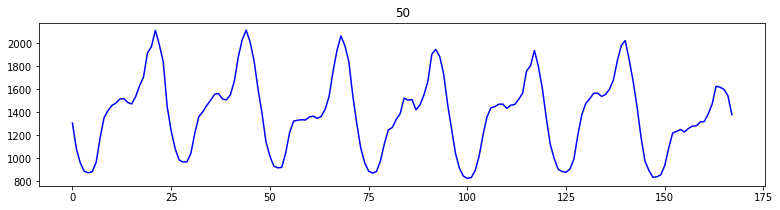

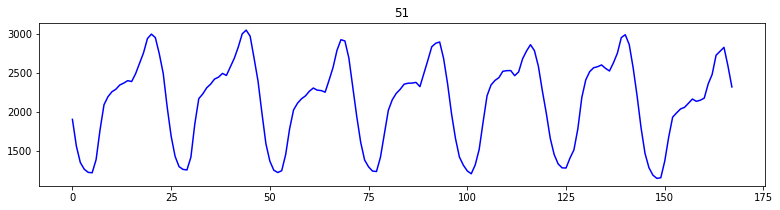

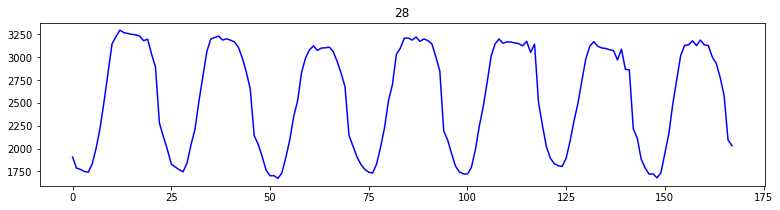

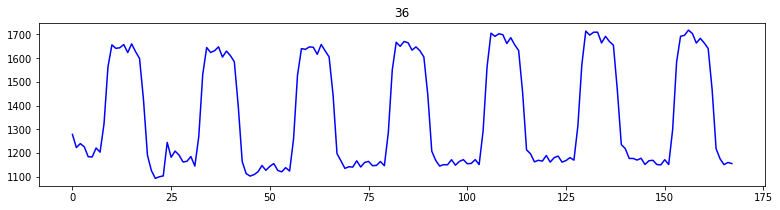

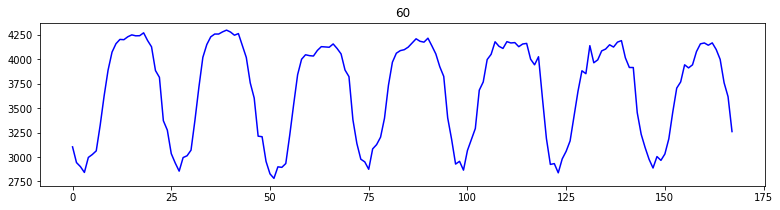

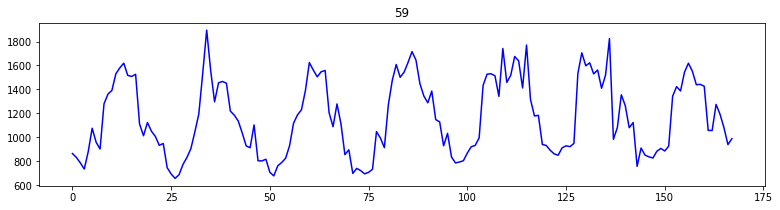

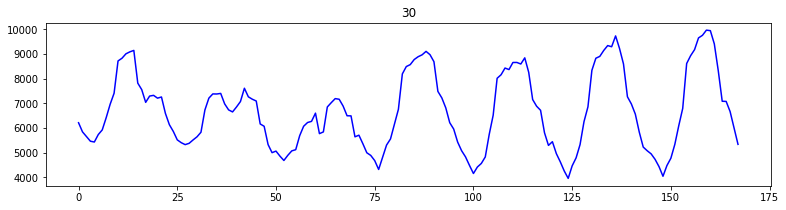

In [7]:
if show_graph:
    for item in real_prediction_bag:
        plt.rcParams["figure.figsize"] = (13,3)
        fig = plt.figure()
        graph = fig.add_subplot(1, 1, 1)
        graph.set_title(f"{item[0]}")
        graph.plot(item[1], color='blue')
        plt.show()